In [ ]:
from annotator_metrics.util.doc_io import MaskInformation
mi = MaskInformation()
test = "mito_mem (3)"
print(test.split("(")[0].split(" ")[0])
for row in mi.rows:
    print(row.organelle_info)

In [ ]:
from annotator_metrics.util.doc_io import MaskInformation
from annotator_metrics.src.preprocessing import copy_data
mi = MaskInformation()
print(mi.rows)
copy_data(group = "group1", output_base_path="/groups/cosem/cosem/ackermand/annotation_and_analytics/tmp/")

In [ ]:
from annotator_metrics.util.doc_io import MaskInformation
mi = MaskInformation()
print(mi.rows[0].organelle_info)


In [ ]:
import numpy as np
a=np.random.random((4,4,4))

In [8]:
from annotator_metrics.util.doc_io import MaskInformation
a=MaskInformation()
print(a.rows[1].organelle_info)

{'mito_mem': 3, 'mito_lumen': 4, 'mito_dna': 5, 'mito': [3, 4, 5]}


In [1]:
from annotator_metrics.src.metrics_evaluations import calculate_all_to_all
calculate_all_to_all("group1","/groups/cosem/cosem/ackermand/annotation_and_analytics/tmp/", num_workers = 10)

distributed.diskutils - INFO - Found stale lock file and directory '/groups/scicompsoft/home/ackermand/Programming/annotator-metrics/dask-worker-space/worker-b49zkjes', purging
distributed.diskutils - INFO - Found stale lock file and directory '/groups/scicompsoft/home/ackermand/Programming/annotator-metrics/dask-worker-space/worker-g2c642w9', purging
distributed.diskutils - INFO - Found stale lock file and directory '/groups/scicompsoft/home/ackermand/Programming/annotator-metrics/dask-worker-space/worker-13oko74x', purging
distributed.diskutils - INFO - Found stale lock file and directory '/groups/scicompsoft/home/ackermand/Programming/annotator-metrics/dask-worker-space/worker-qj276vid', purging
distributed.diskutils - INFO - Found stale lock file and directory '/groups/scicompsoft/home/ackermand/Programming/annotator-metrics/dask-worker-space/worker-zo9122ms', purging
distributed.diskutils - INFO - Found stale lock file and directory '/groups/scicompsoft/home/ackermand/Programming/

http://10.150.100.248:8787/status


/groups/scicompsoft/home/ackermand/Programming/annotator-metrics/annotator_metrics/src/metrics_evaluations.py:198: RuntimeWarning: Mean of empty slice
  sort_order = np.argsort(np.nanmean(all_to_all, axis=1))
/groups/scicompsoft/home/ackermand/Programming/annotator-metrics/annotator_metrics/src/metrics_evaluations.py:198: RuntimeWarning: Mean of empty slice
  sort_order = np.argsort(np.nanmean(all_to_all, axis=1))
/groups/scicompsoft/home/ackermand/Programming/annotator-metrics/annotator_metrics/src/metrics_evaluations.py:202: RuntimeWarning: Mean of empty slice
  sort_order = np.argsort(np.nanmean(all_to_all, axis=1))[::-1]
/groups/scicompsoft/home/ackermand/Programming/annotator-metrics/annotator_metrics/src/metrics_evaluations.py:202: RuntimeWarning: Mean of empty slice
  sort_order = np.argsort(np.nanmean(all_to_all, axis=1))[::-1]
/groups/scicompsoft/home/ackermand/Programming/annotator-metrics/annotator_metrics/src/metrics_evaluations.py:202: RuntimeWarning: Mean of empty slice
 

mito_mem F1 Score
(8, 8) 0.35537068117195014 0.9791584822532817 rocket
mito_mem F1 Score
(8, 8) 0.3553706811719501 0.9791584822532817 rocket
mito_lumen F1 Score
(8, 8) 0.447282137394533 0.9999977912706599 rocket
mito_lumen F1 Score
(8, 8) 0.447282137394533 0.9999977912706599 rocket
mito F1 Score
(8, 8) 1.0 1.0 rocket
mito F1 Score
(8, 8) 1.0 1.0 rocket
mito_mem F1 Score
(8, 8) 0.35537068117195014 0.9791584822532817 rocket
mito_mem F1 Score
(8, 8) 0.3553706811719501 0.9791584822532817 rocket
mito_lumen F1 Score
(8, 8) 0.447282137394533 0.9999977912706599 rocket
mito_lumen F1 Score
(8, 8) 0.447282137394533 0.9999977912706599 rocket
mito_dna F1 Score
(8, 8) 0.0 0.8696083581392634 rocket
mito_dna F1 Score
(8, 8) 0.43970728603245307 0.8696083581392634 rocket


/groups/scicompsoft/home/ackermand/Programming/annotator-metrics/annotator_metrics/src/metrics_evaluations.py:206: RuntimeWarning: Mean of empty slice
  sort_order = np.argsort(np.nanmean(all_to_all, axis=1))[::-1]


mito F1 Score
(8, 8) 1.0 1.0 rocket
mito F1 Score
(8, 8) 1.0 1.0 rocket
mito_mem F1 Score
(8, 8) 0.35537068117195014 0.9791584822532817 rocket
mito_mem F1 Score
(8, 8) 0.3553706811719501 0.9791584822532817 rocket
mito_lumen F1 Score
(8, 8) 0.447282137394533 0.9999977912706599 rocket
mito_lumen F1 Score
(8, 8) 0.447282137394533 0.9999977912706599 rocket
mito F1 Score
(8, 8) 1.0 1.0 rocket
mito F1 Score
(8, 8) 1.0 1.0 rocket
mito_mem F1 Score
(6, 6) 0.35537068117195014 0.9791584822532817 rocket
mito_mem F1 Score
(6, 6) 0.3553706811719501 0.9791584822532817 rocket


/groups/scicompsoft/home/ackermand/Programming/annotator-metrics/annotator_metrics/src/metrics_evaluations.py:200: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  _, ax = plt.subplots(1, 1, figsize=(8, 6),)


mito_lumen F1 Score
(6, 6) 0.447282137394533 0.9999977912706599 rocket
mito_lumen F1 Score
(6, 6) 0.447282137394533 0.9999977912706599 rocket
mito F1 Score
(6, 6) 1.0 1.0 rocket
mito F1 Score
(6, 6) 1.0 1.0 rocket
mito_mem F1 Score
(6, 6) 0.35537068117195014 0.9791584822532817 rocket
mito_mem F1 Score
(6, 6) 0.3553706811719501 0.9791584822532817 rocket
mito_lumen F1 Score
(6, 6) 0.447282137394533 0.9999977912706599 rocket
mito_lumen F1 Score
(6, 6) 0.447282137394533 0.9999977912706599 rocket
mito F1 Score
(6, 6) 1.0 1.0 rocket
mito F1 Score
(6, 6) 1.0 1.0 rocket
mito_mem F1 Score
(6, 6) 0.35537068117195014 0.9791584822532817 rocket
mito_mem F1 Score
(6, 6) 0.3553706811719501 0.9791584822532817 rocket
mito_lumen F1 Score
(6, 6) 0.447282137394533 0.9999977912706599 rocket
mito_lumen F1 Score
(6, 6) 0.447282137394533 0.9999977912706599 rocket
mito_dna F1 Score
(6, 6) 0.0 0.8696083581392634 rocket
mito_dna F1 Score
(6, 6) 0.43970728603245307 0.8696083581392634 rocket
mito F1 Score
(6, 6) 1

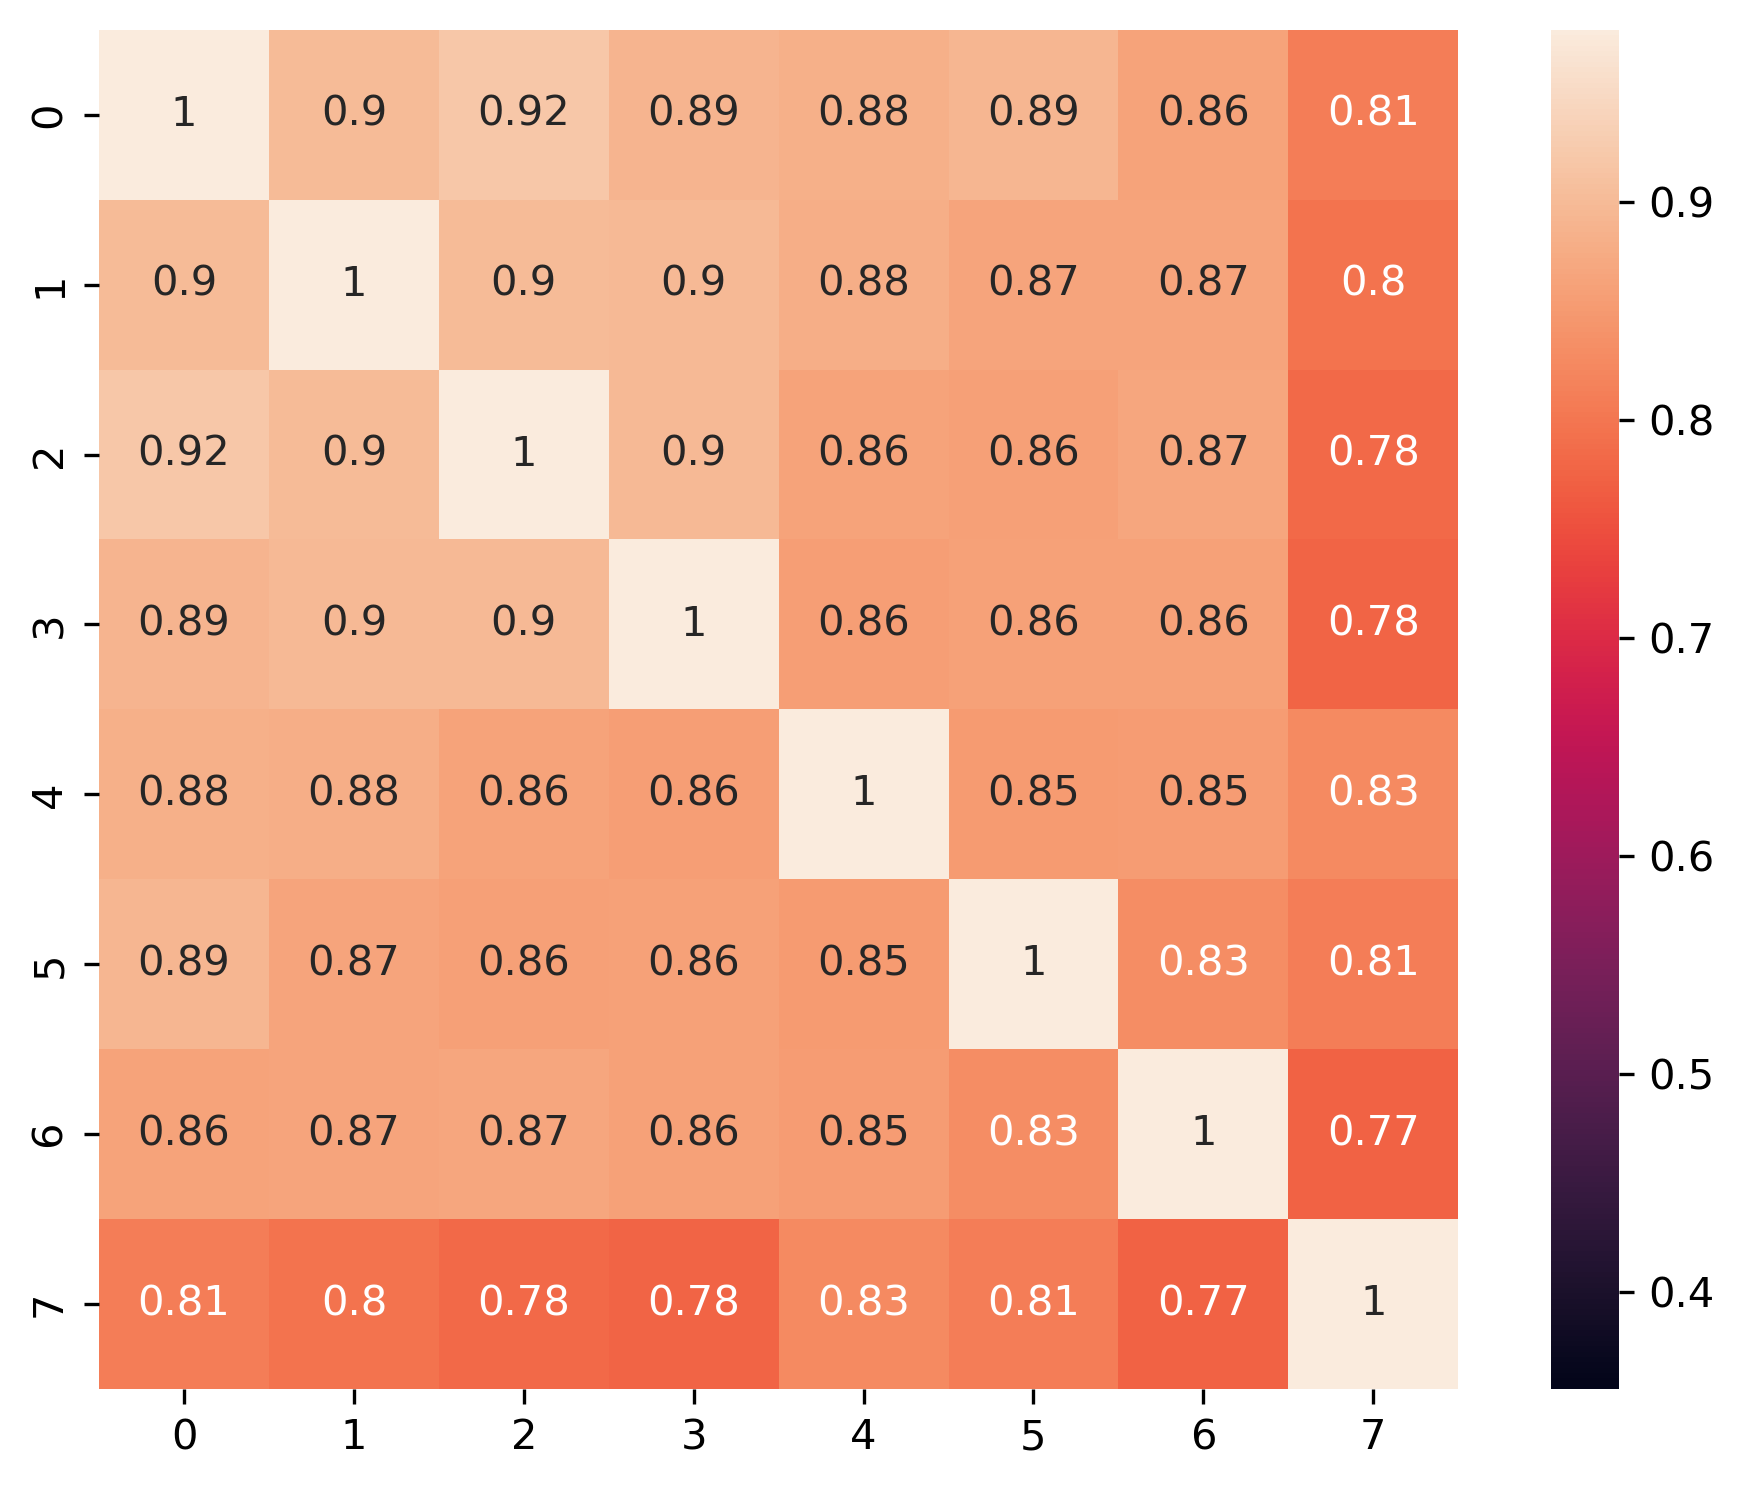

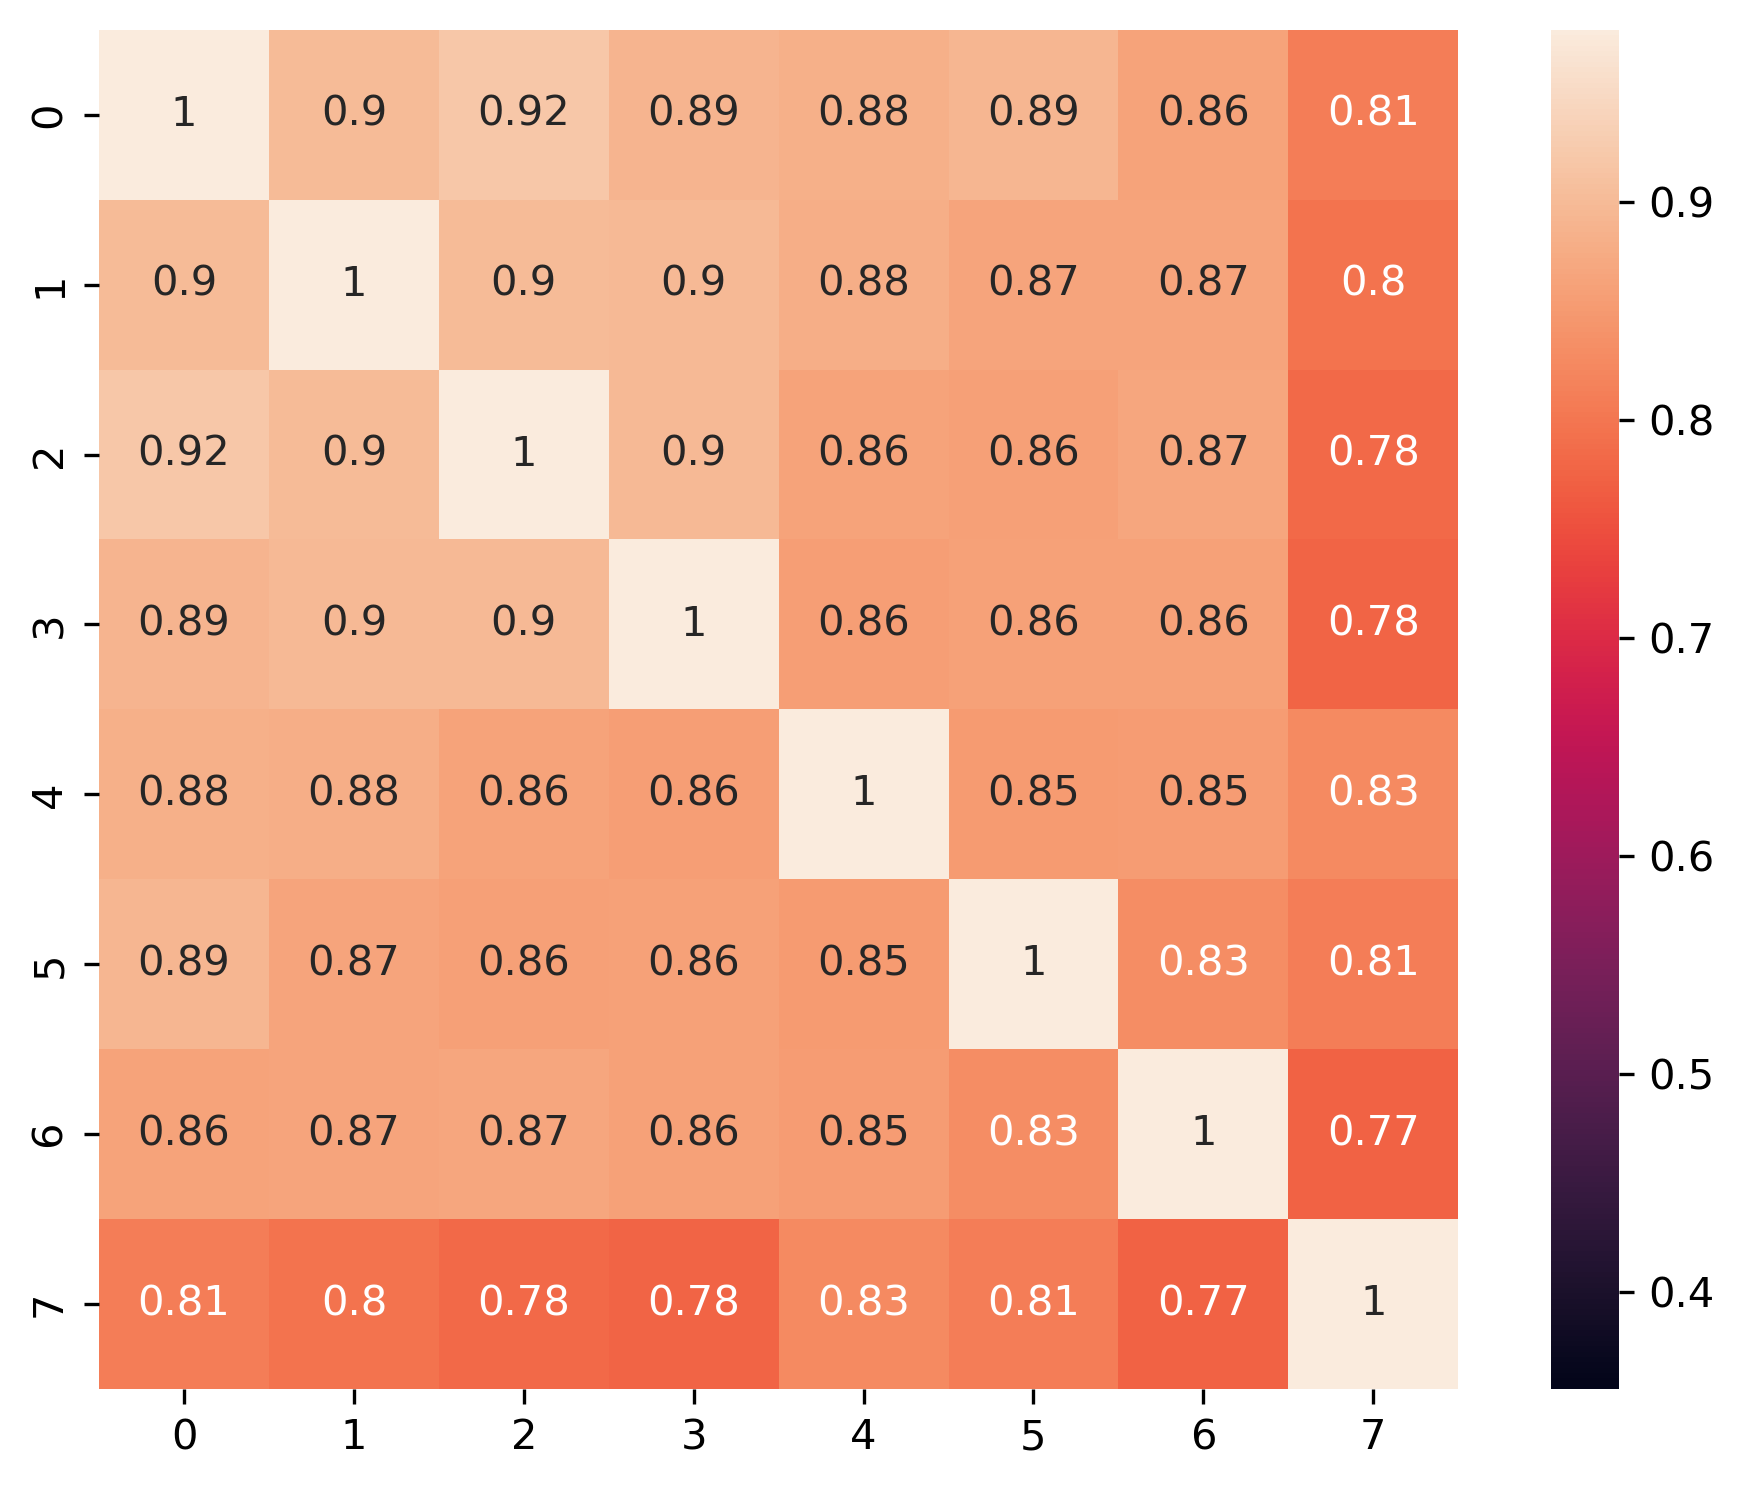

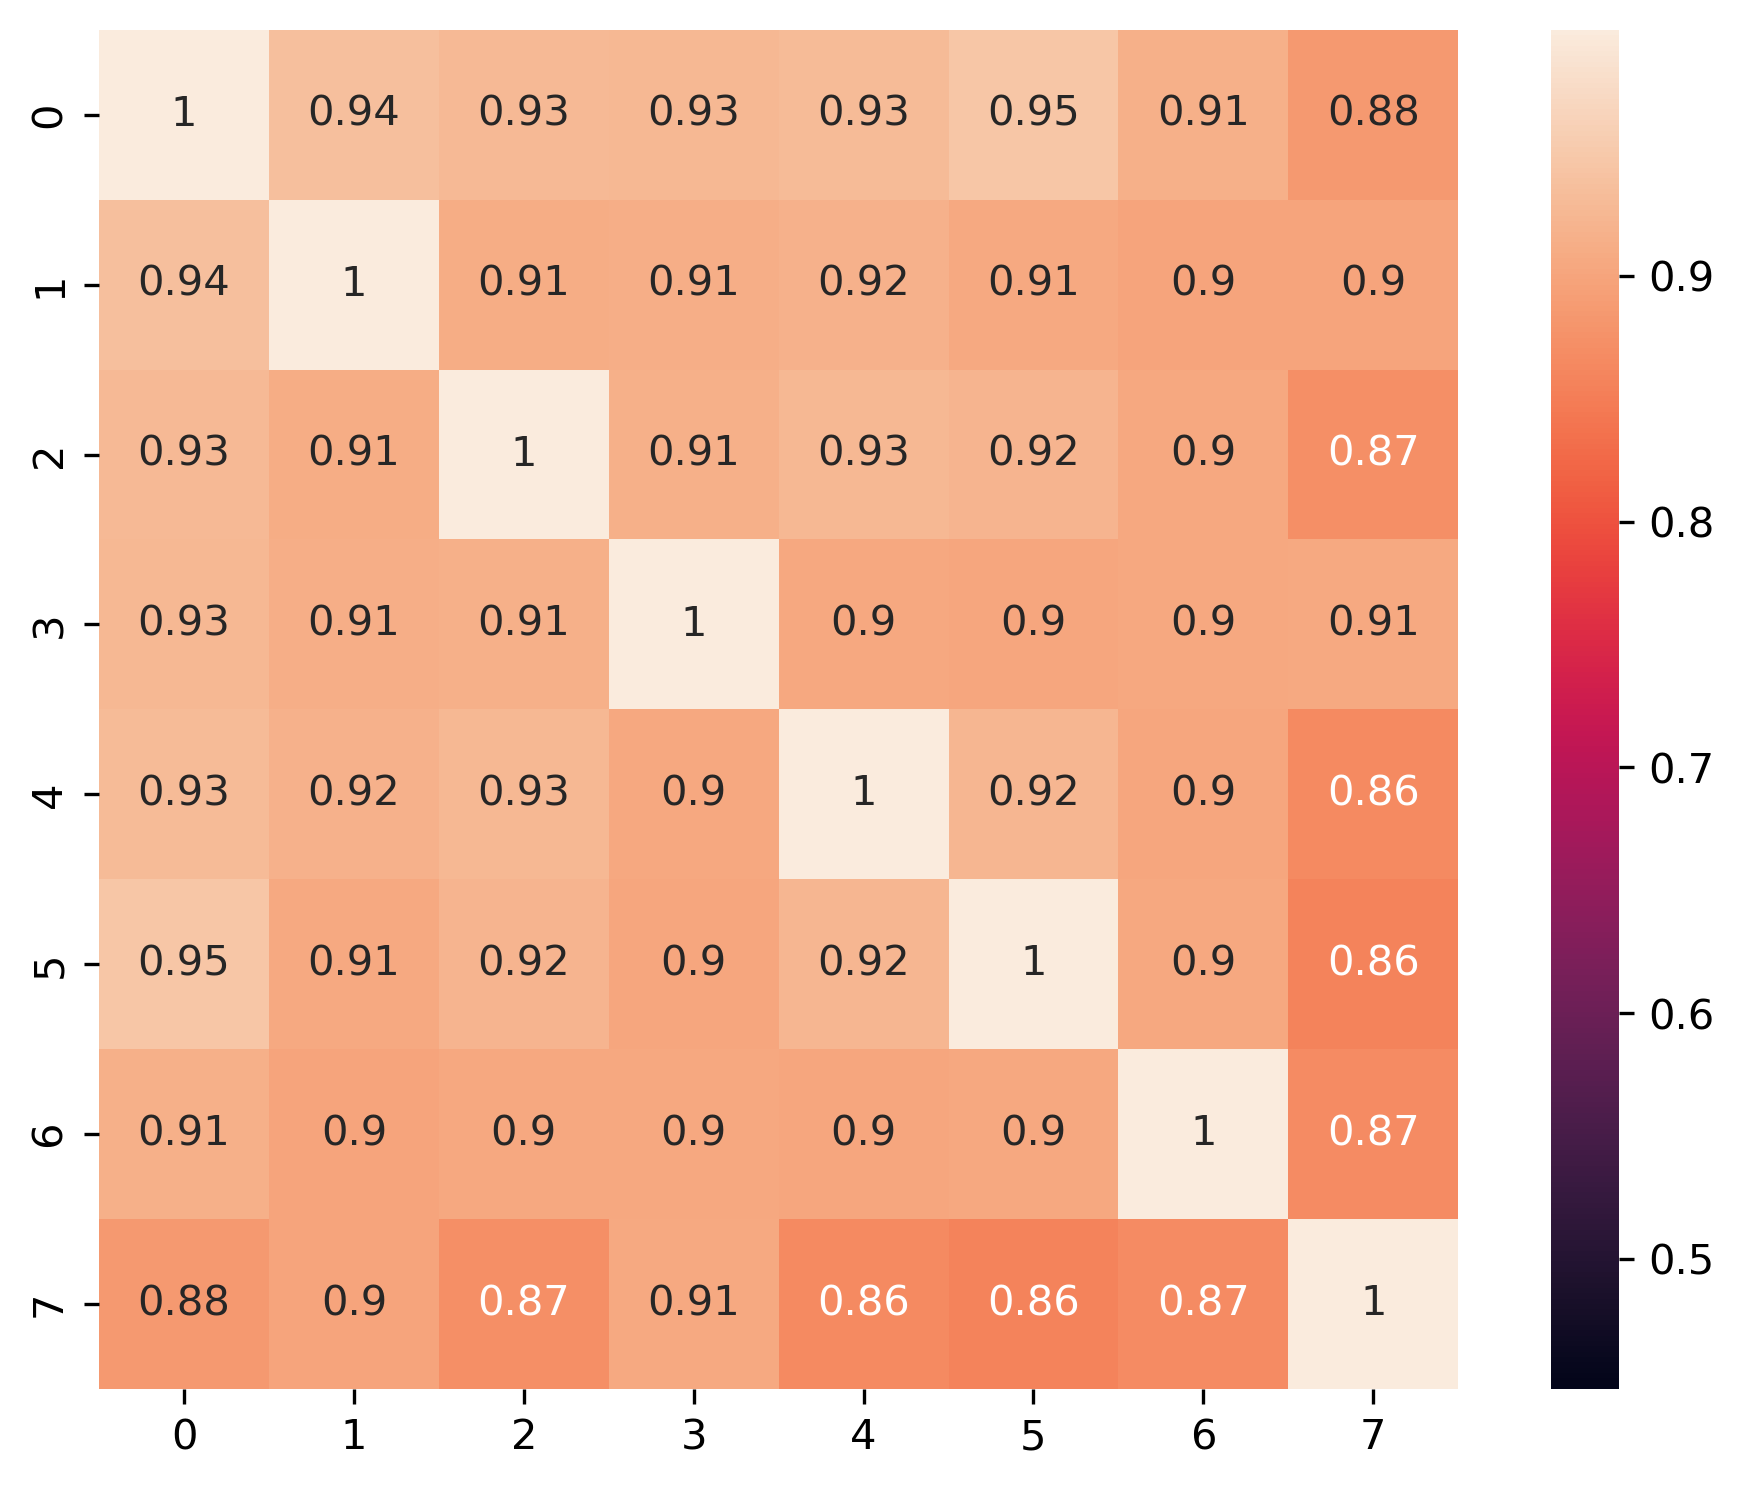

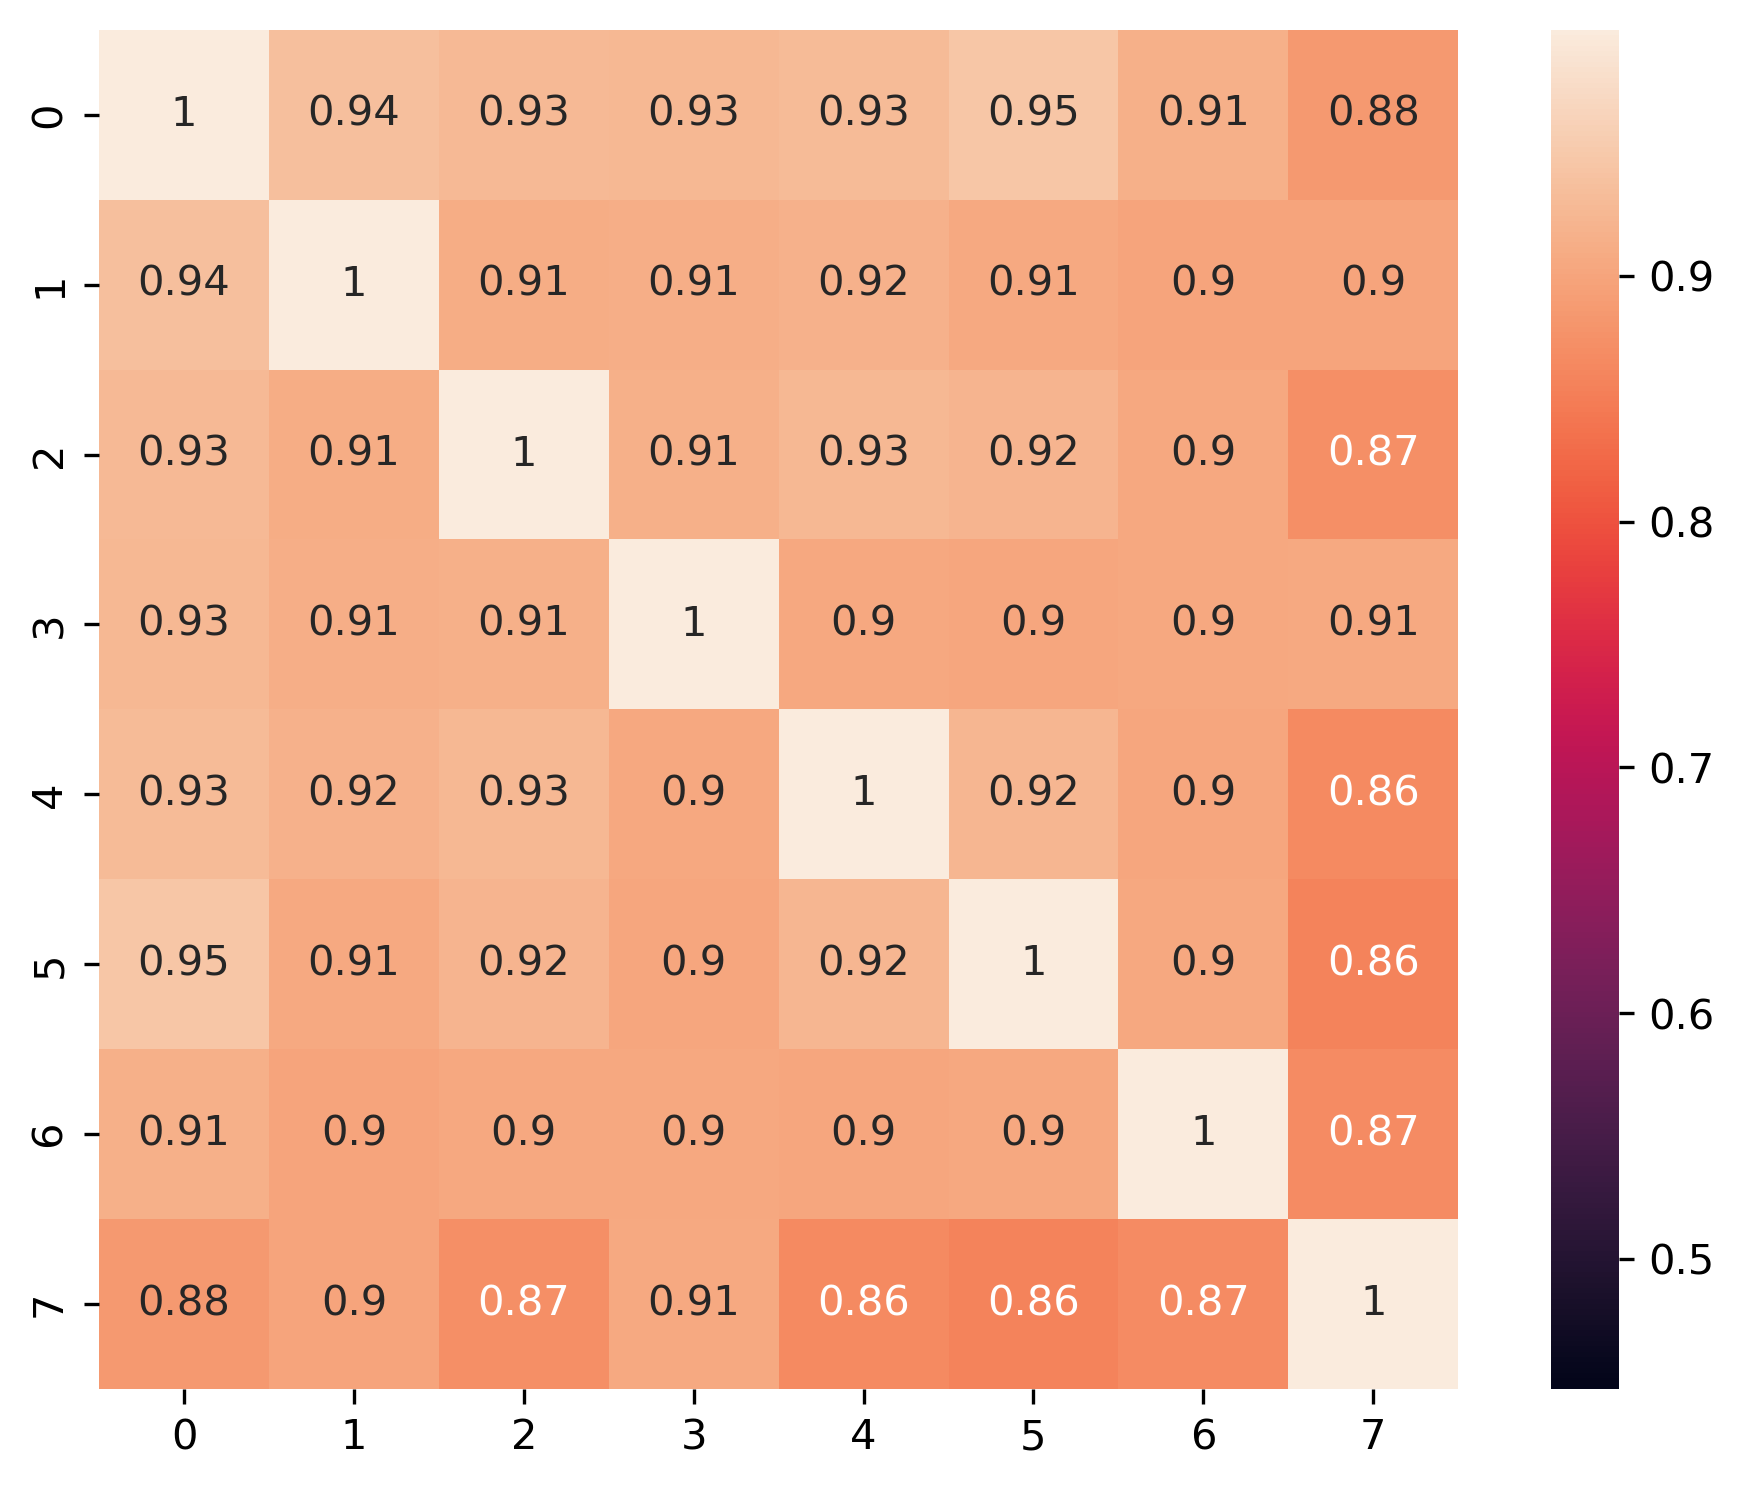

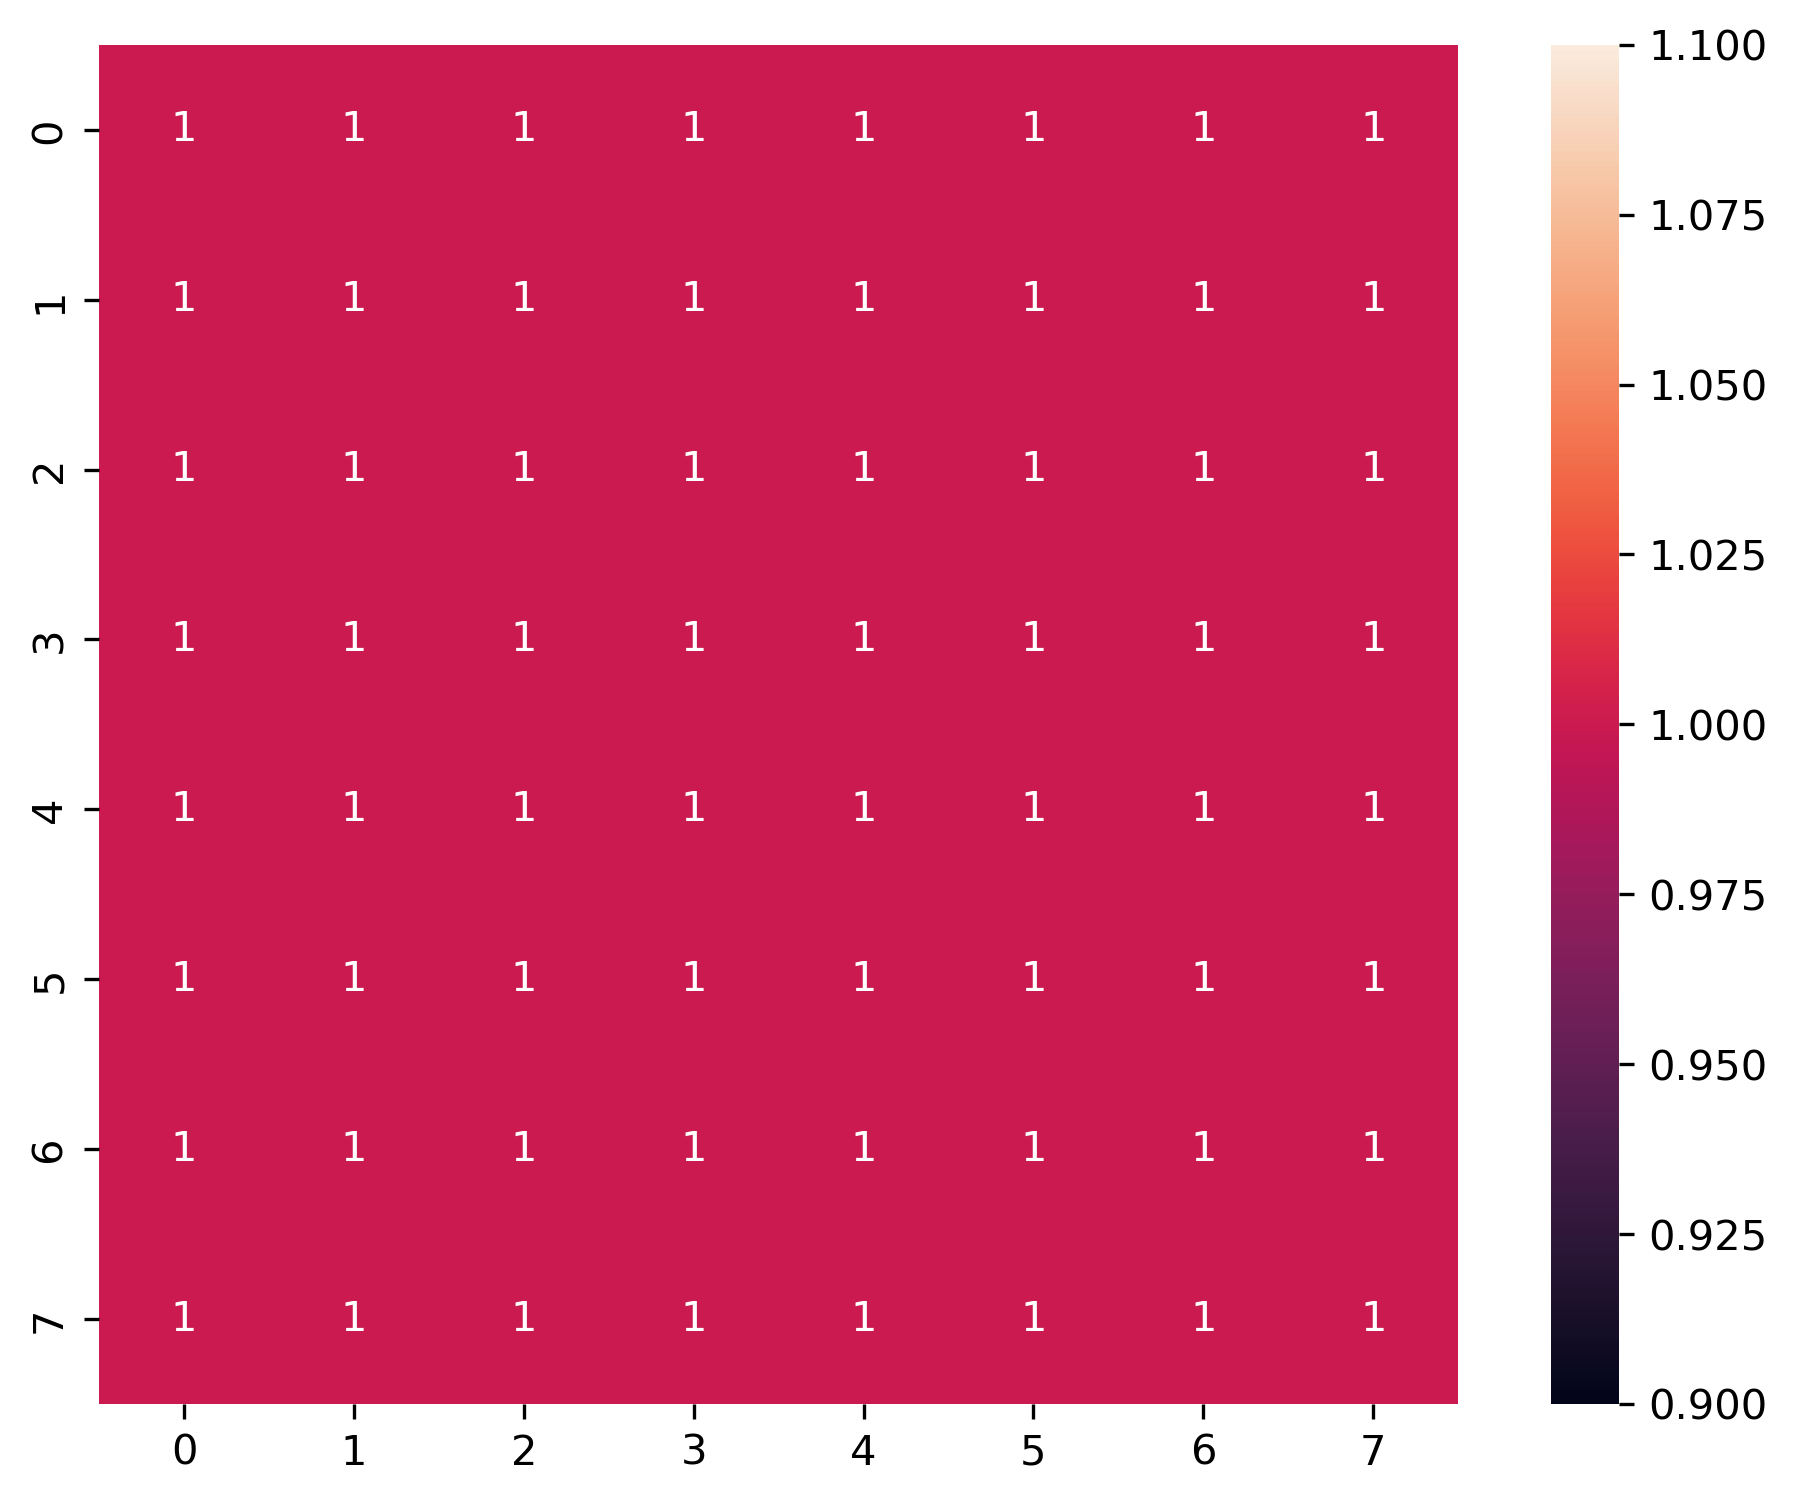

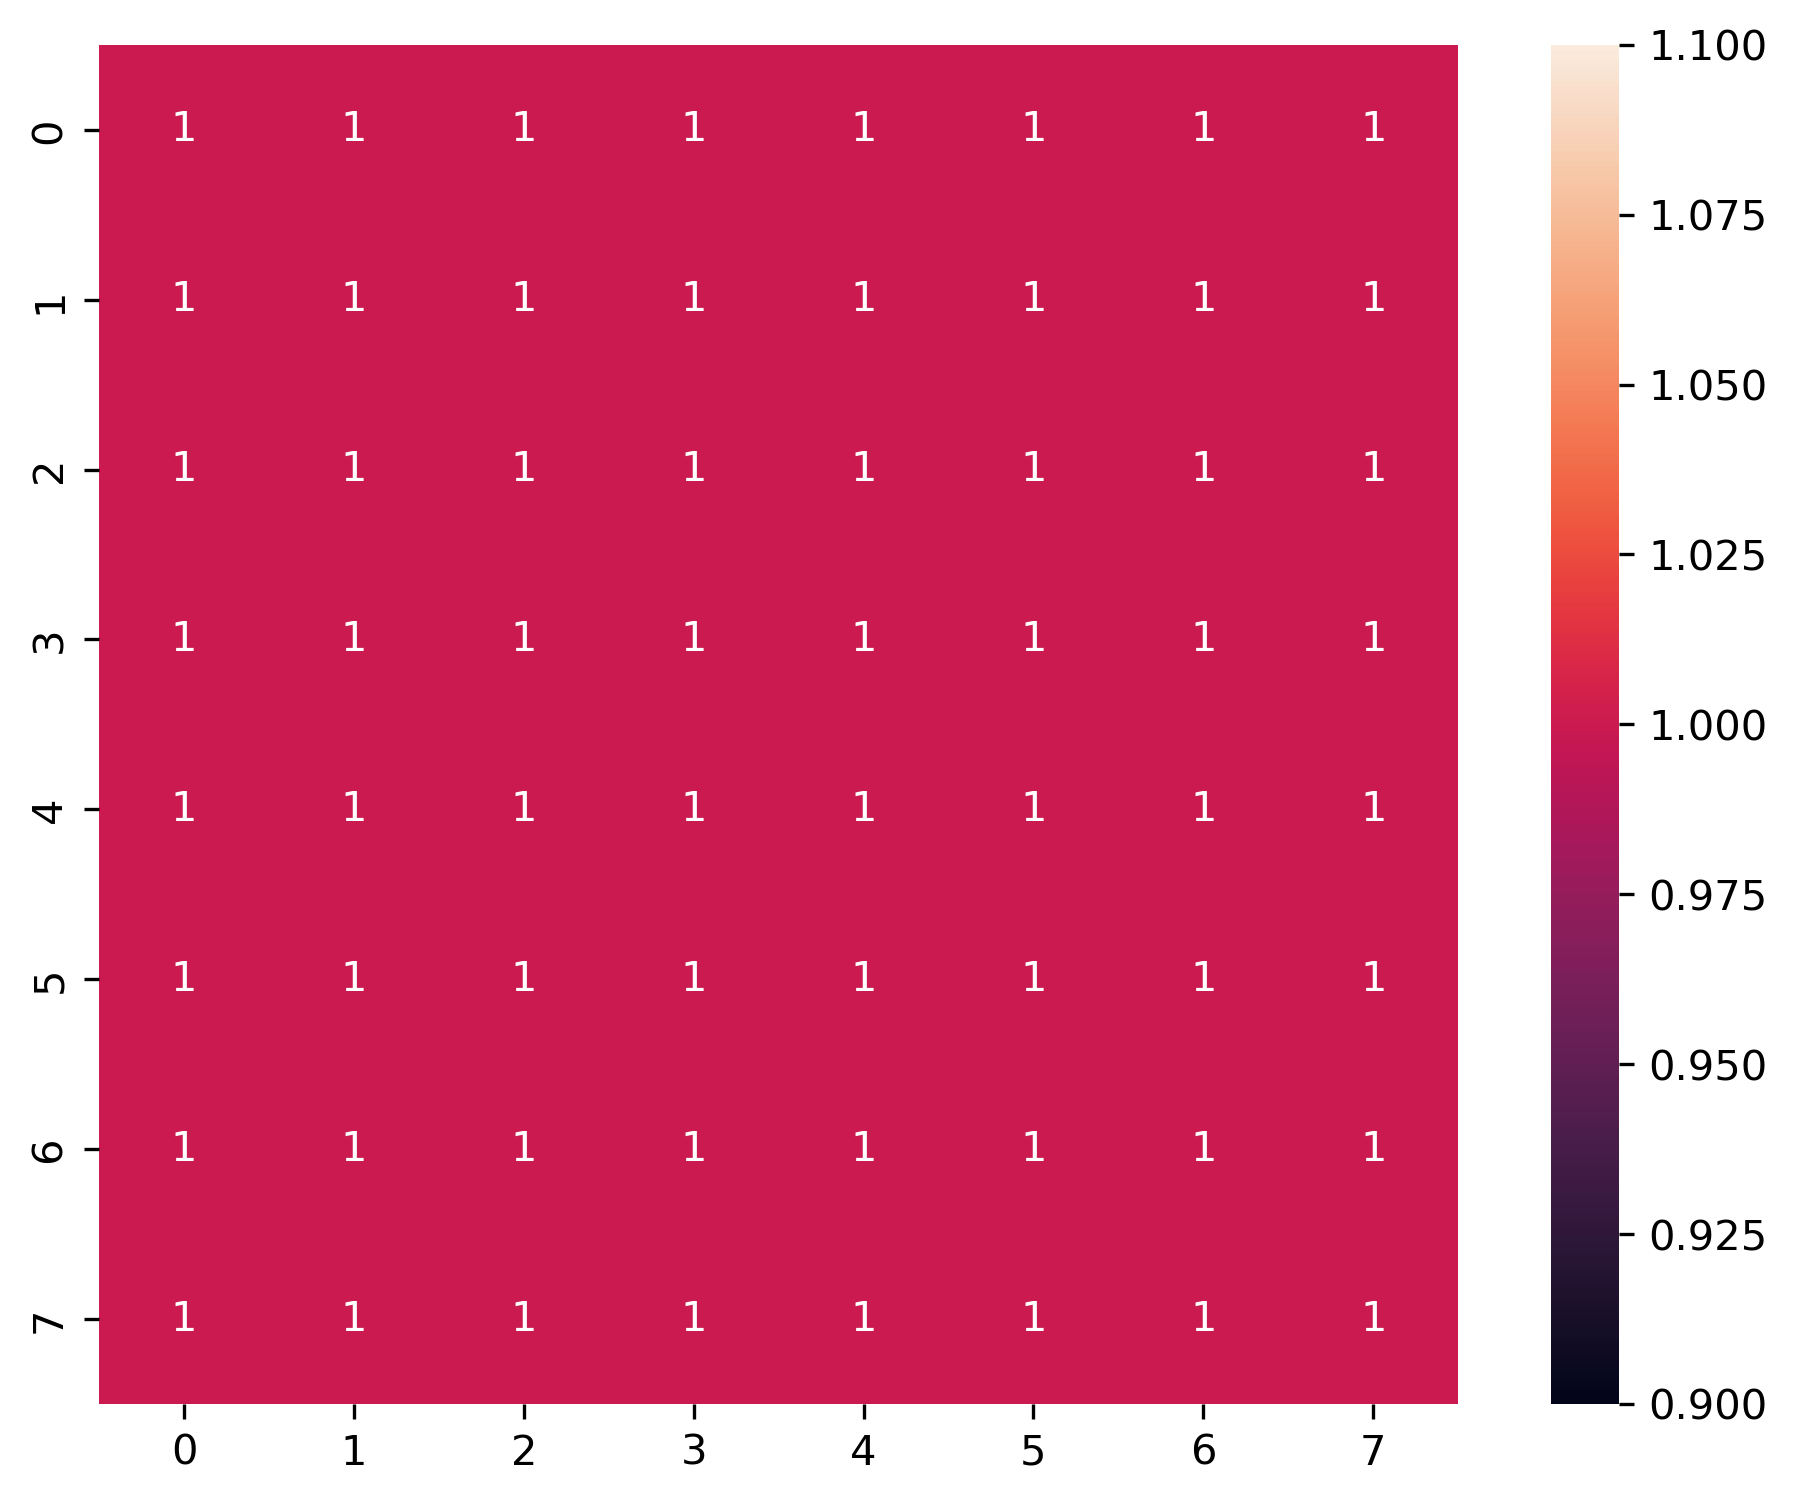

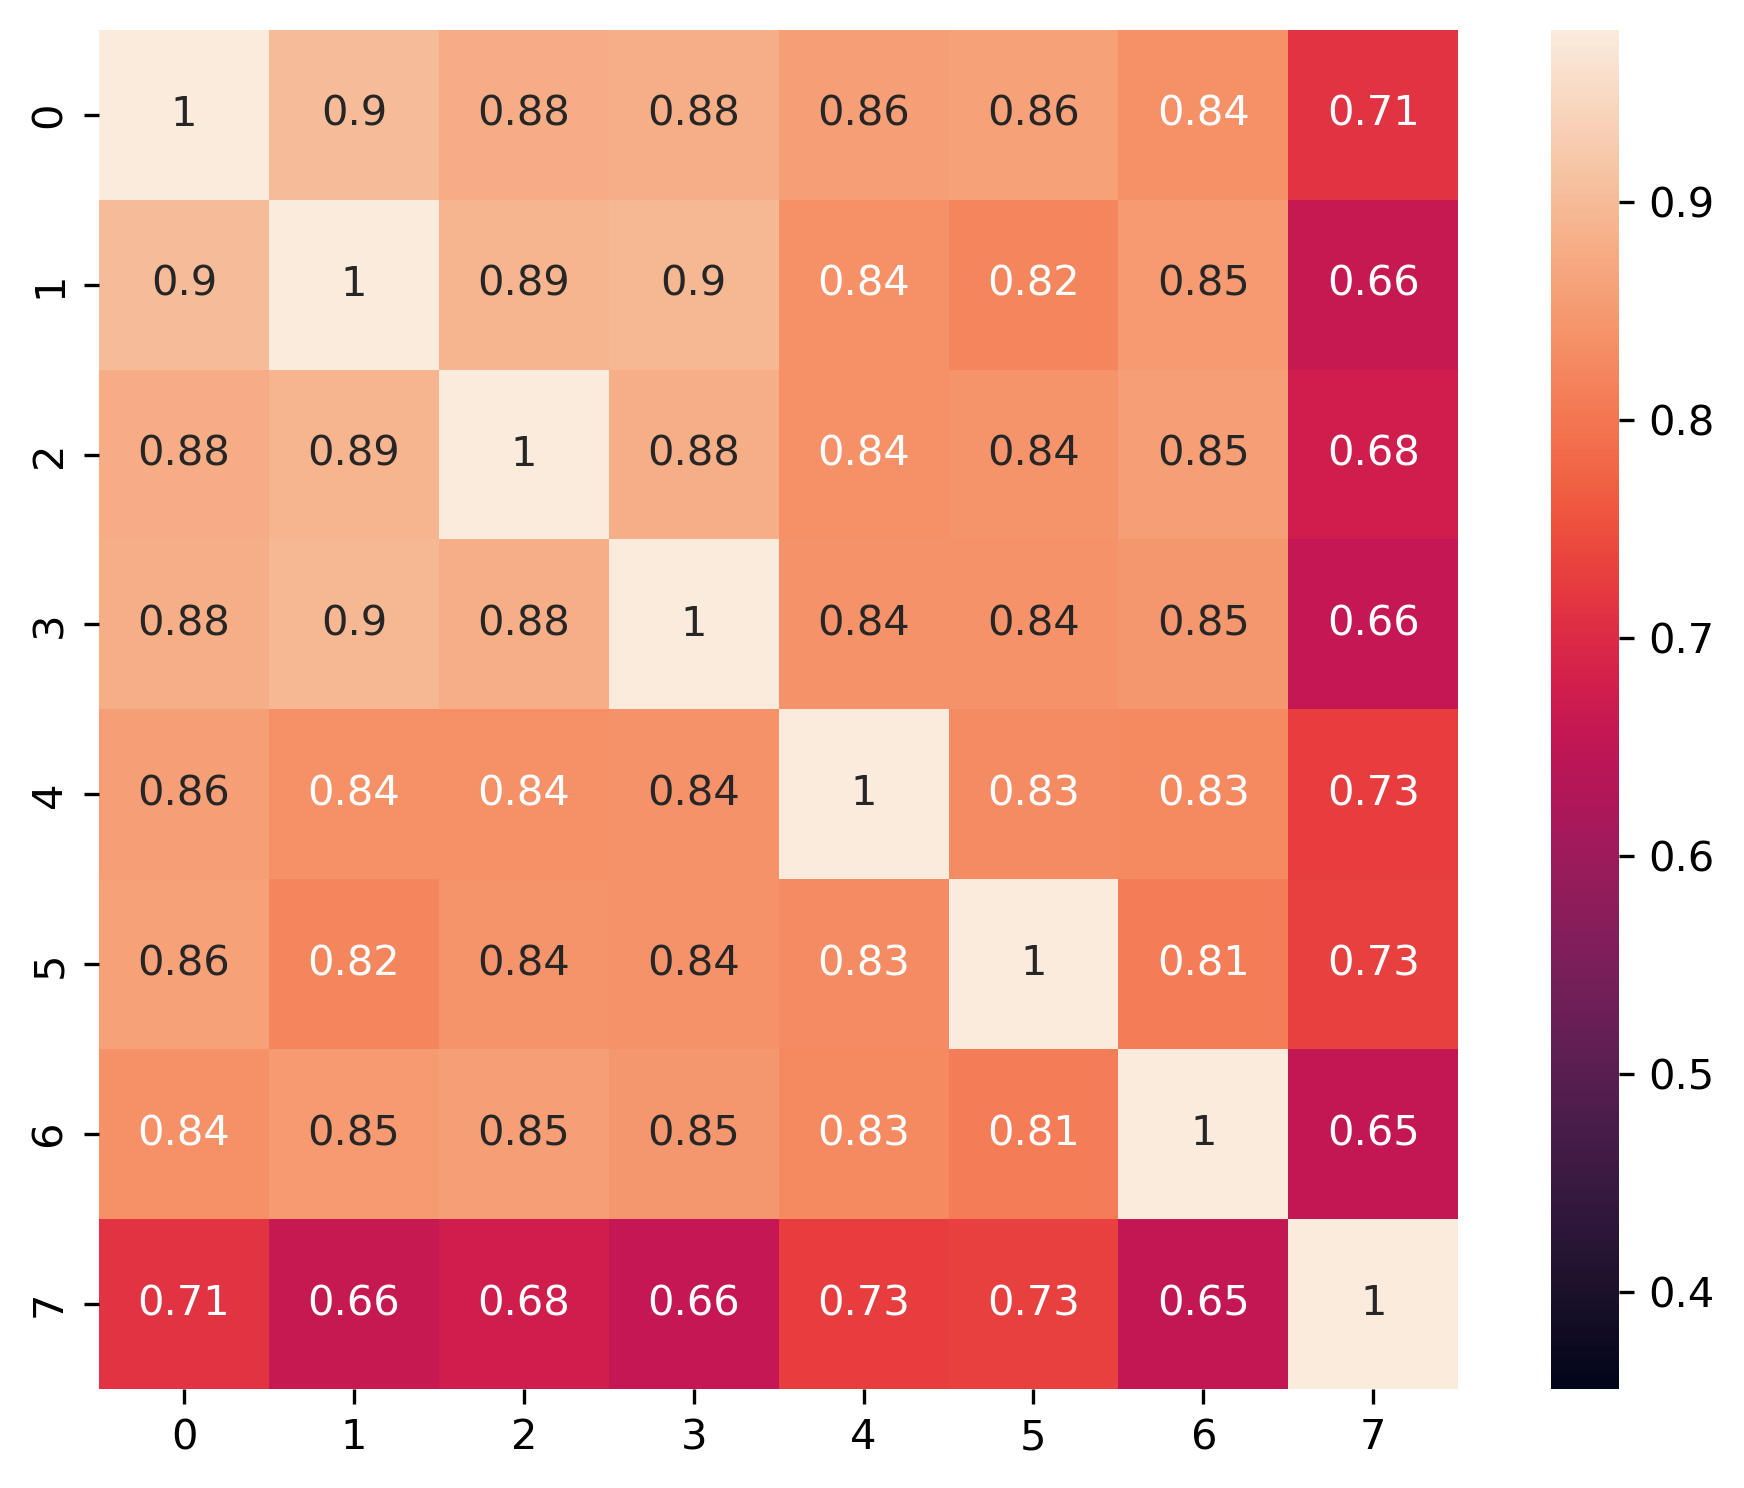

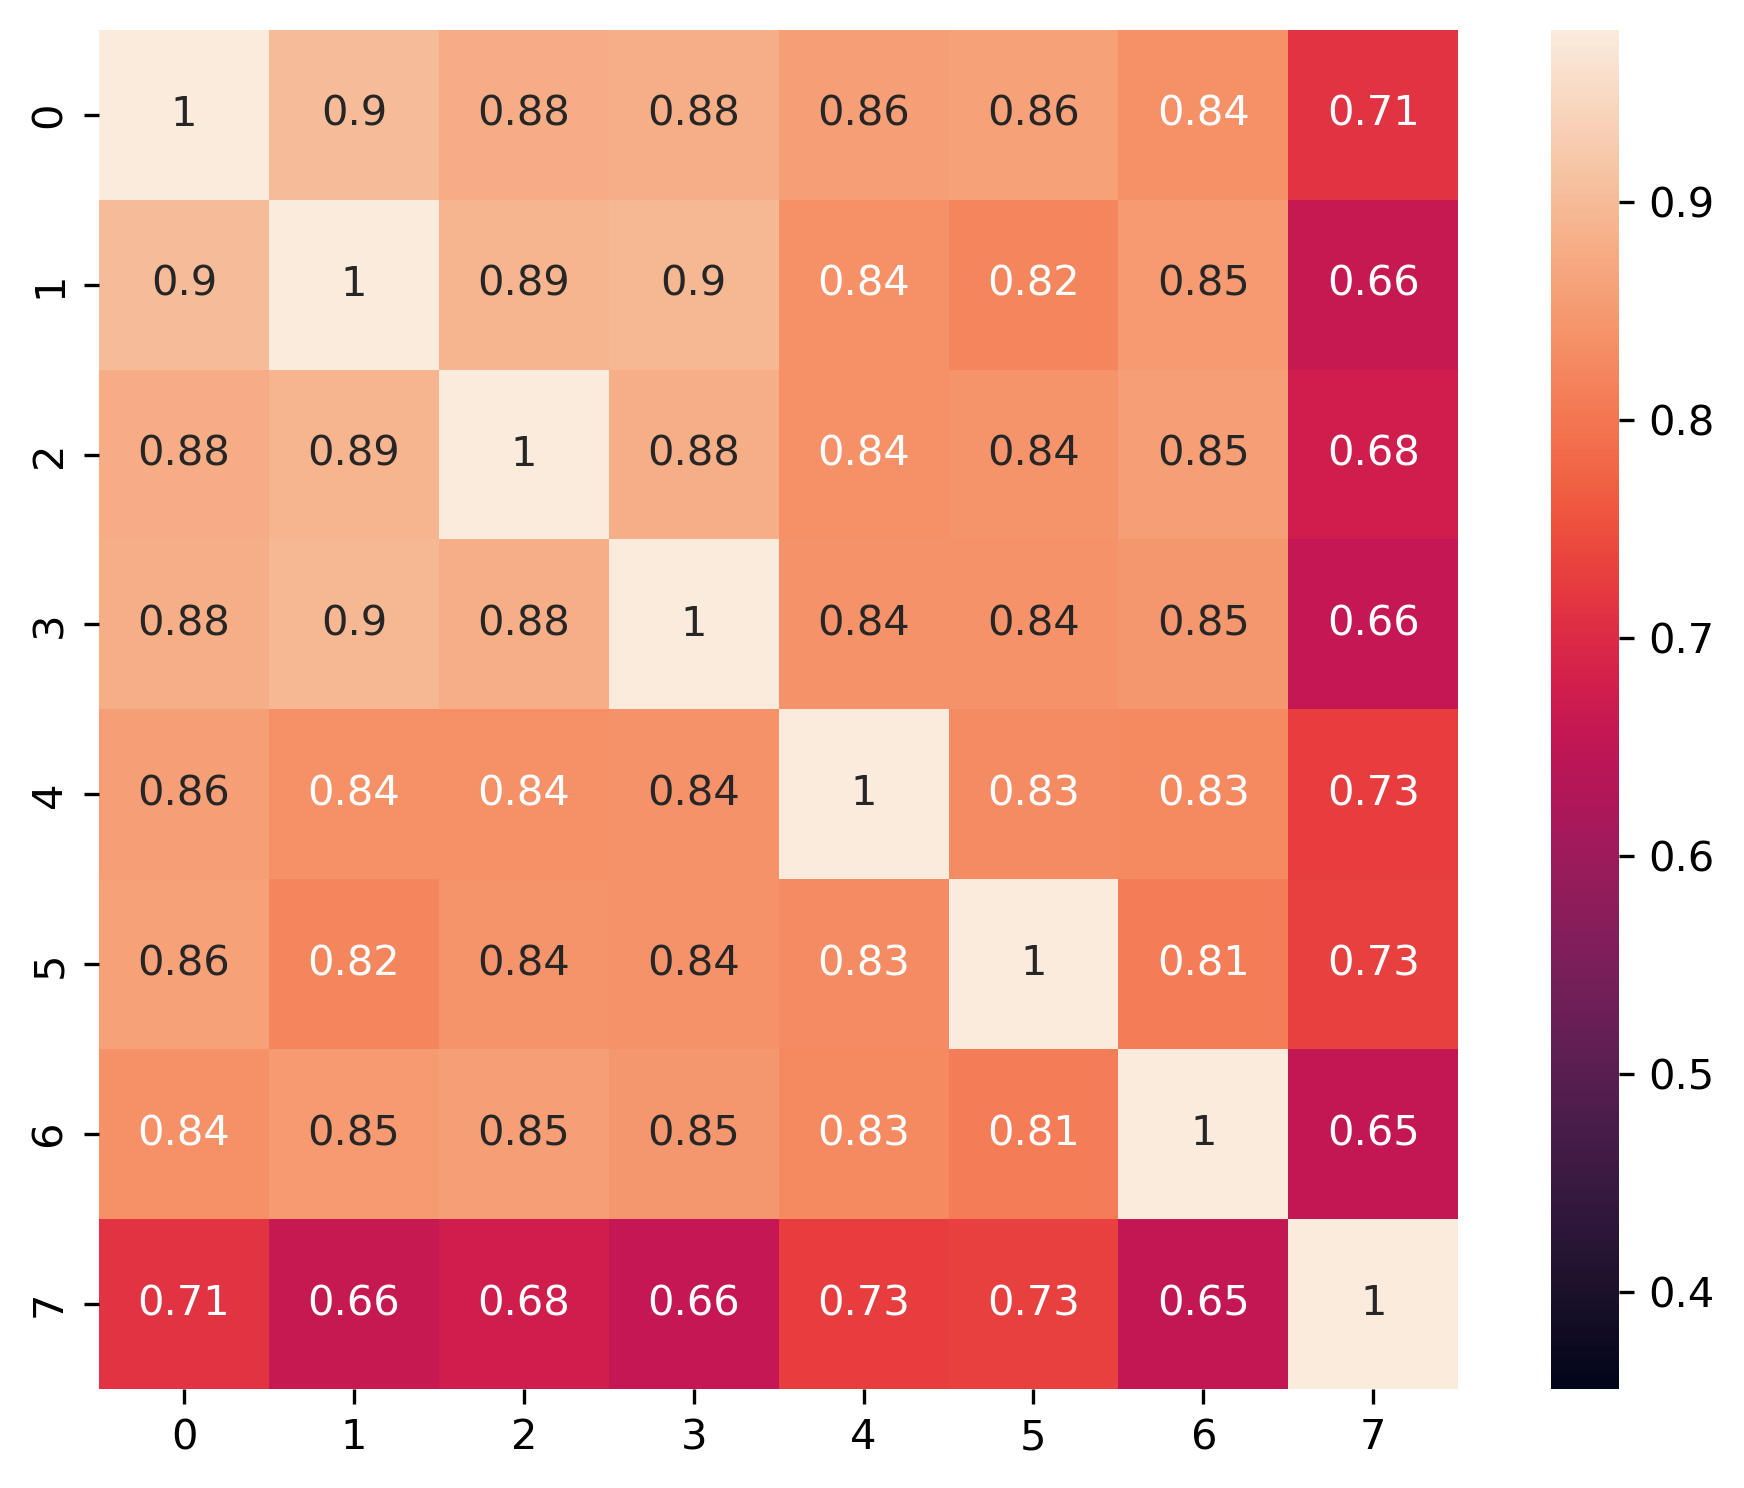

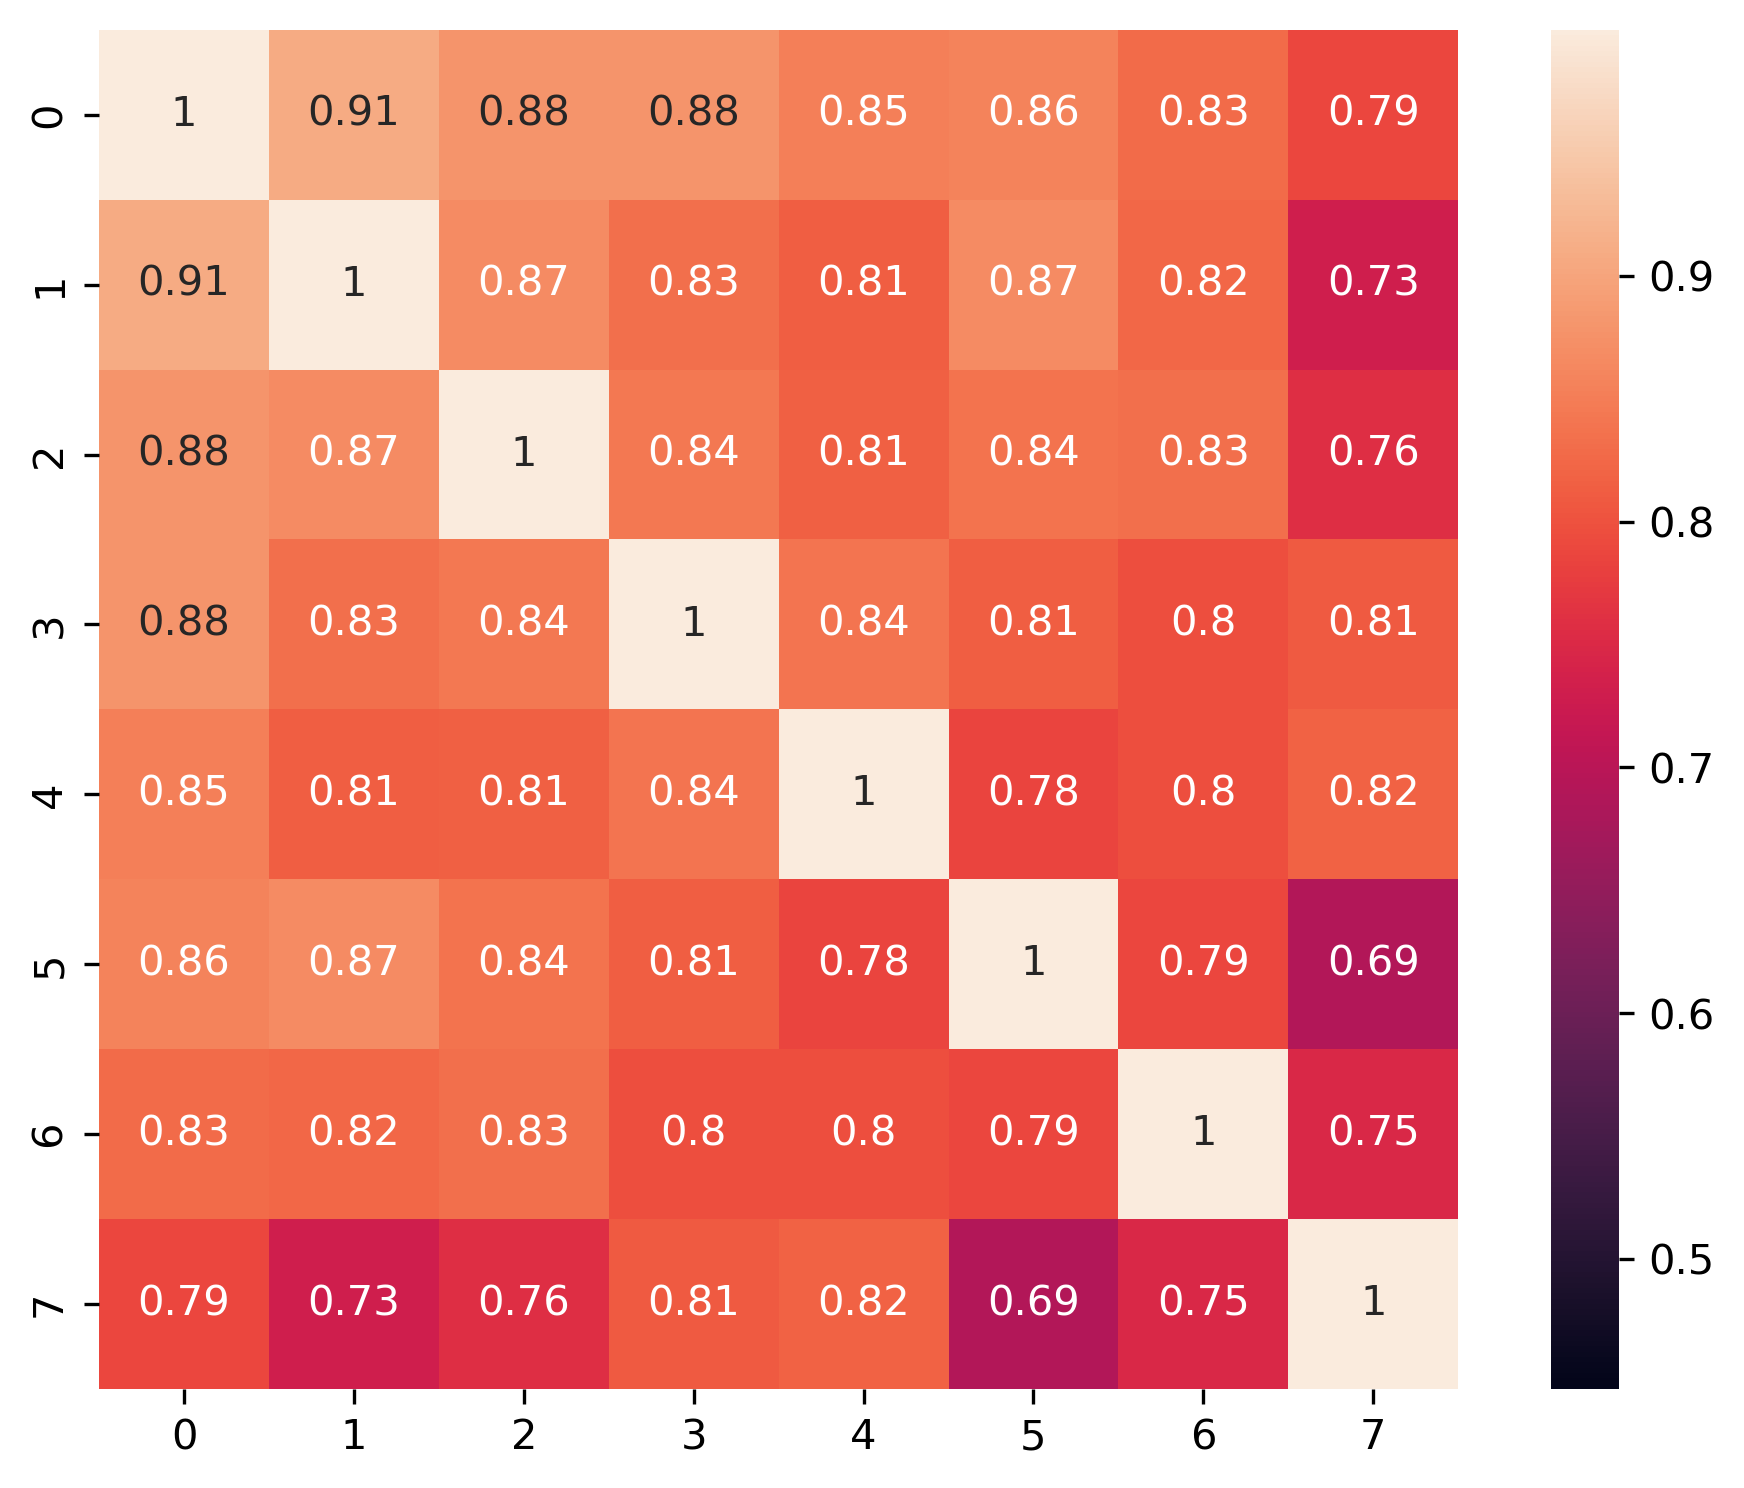

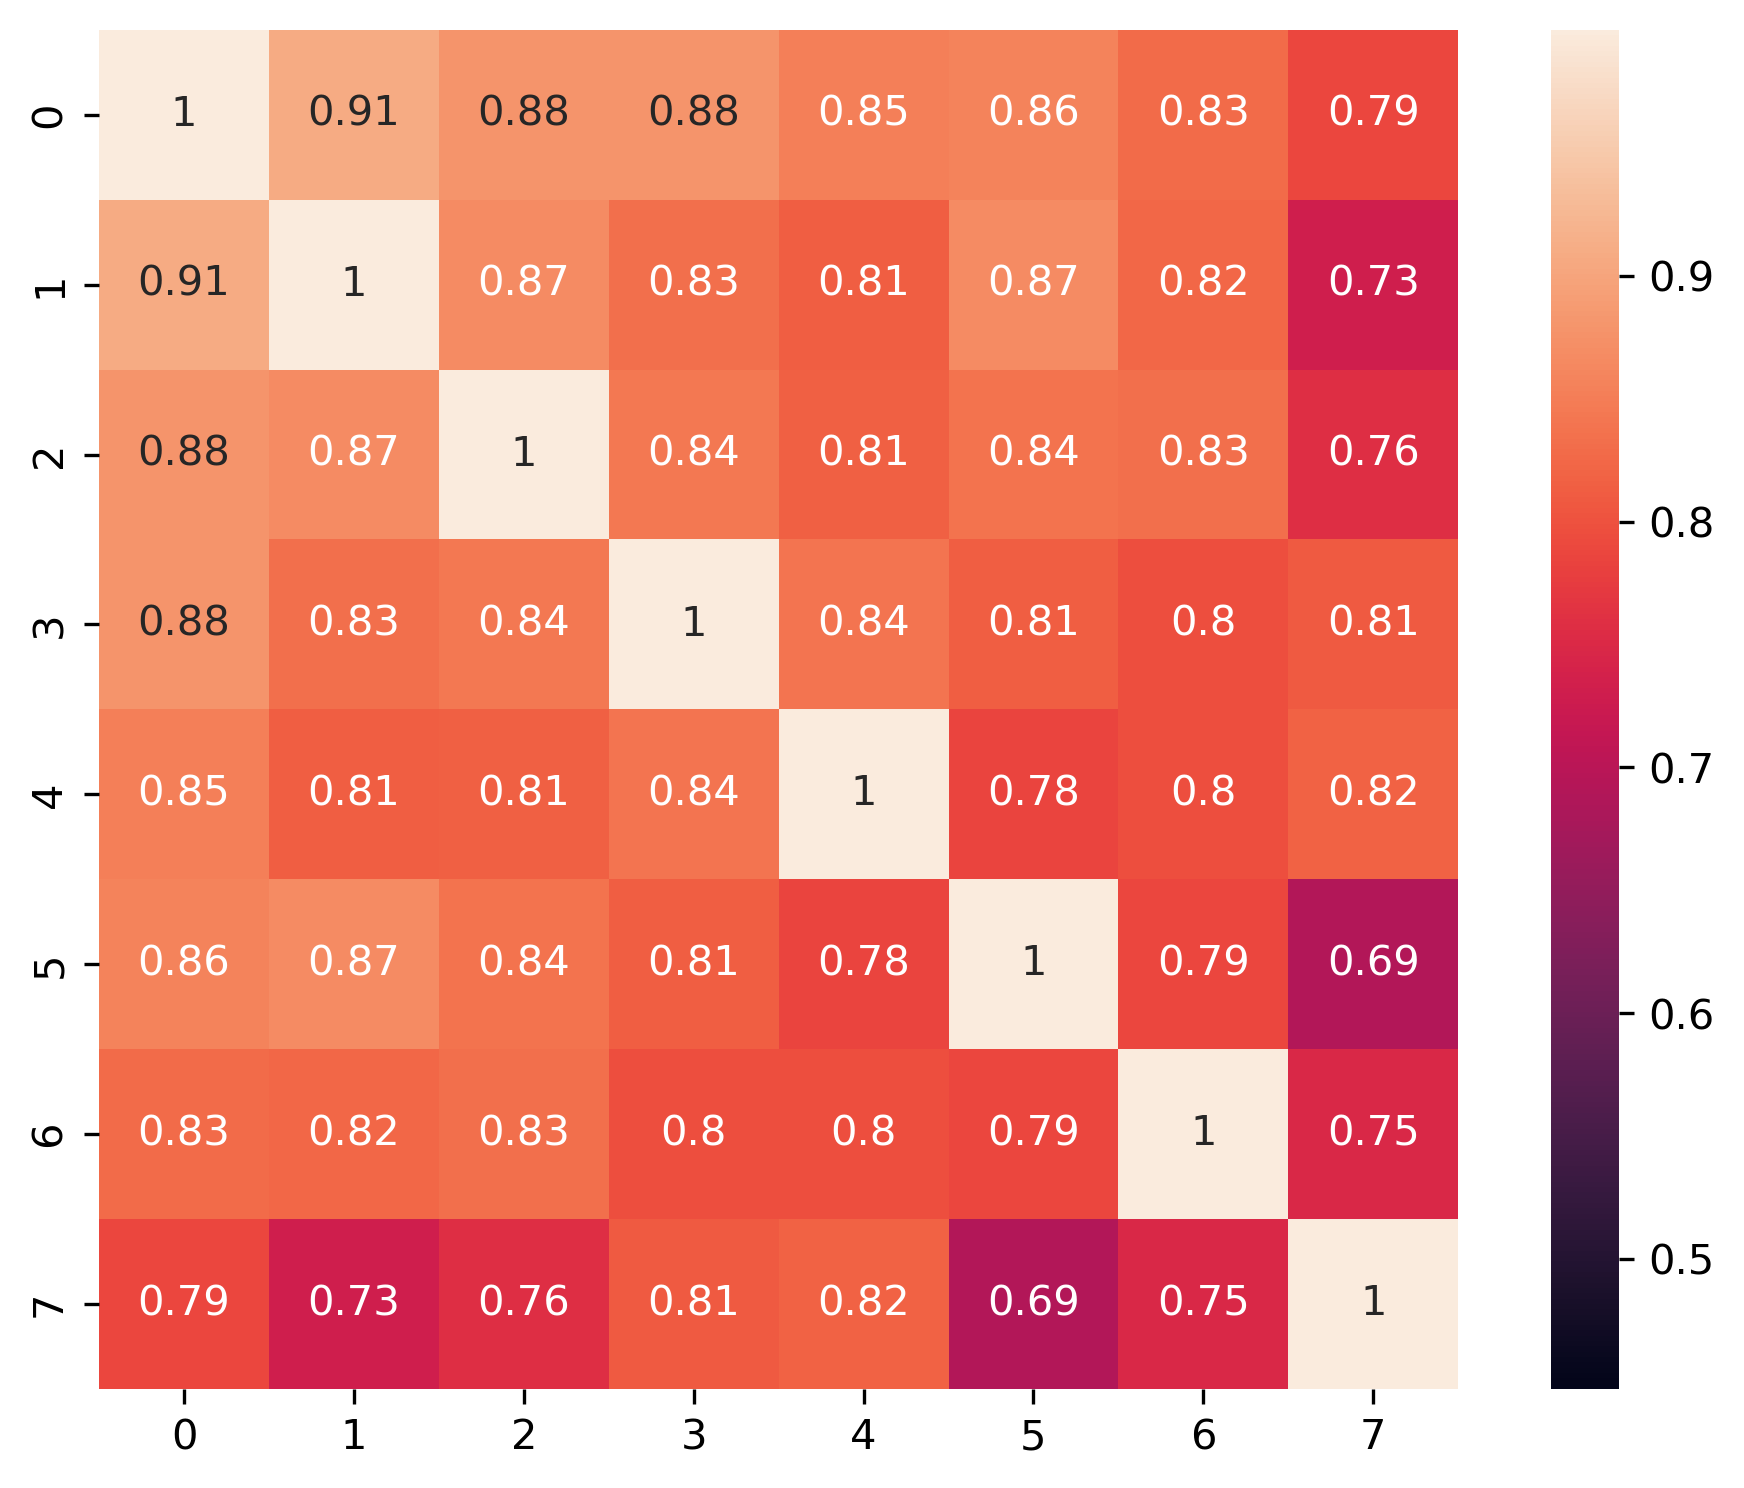

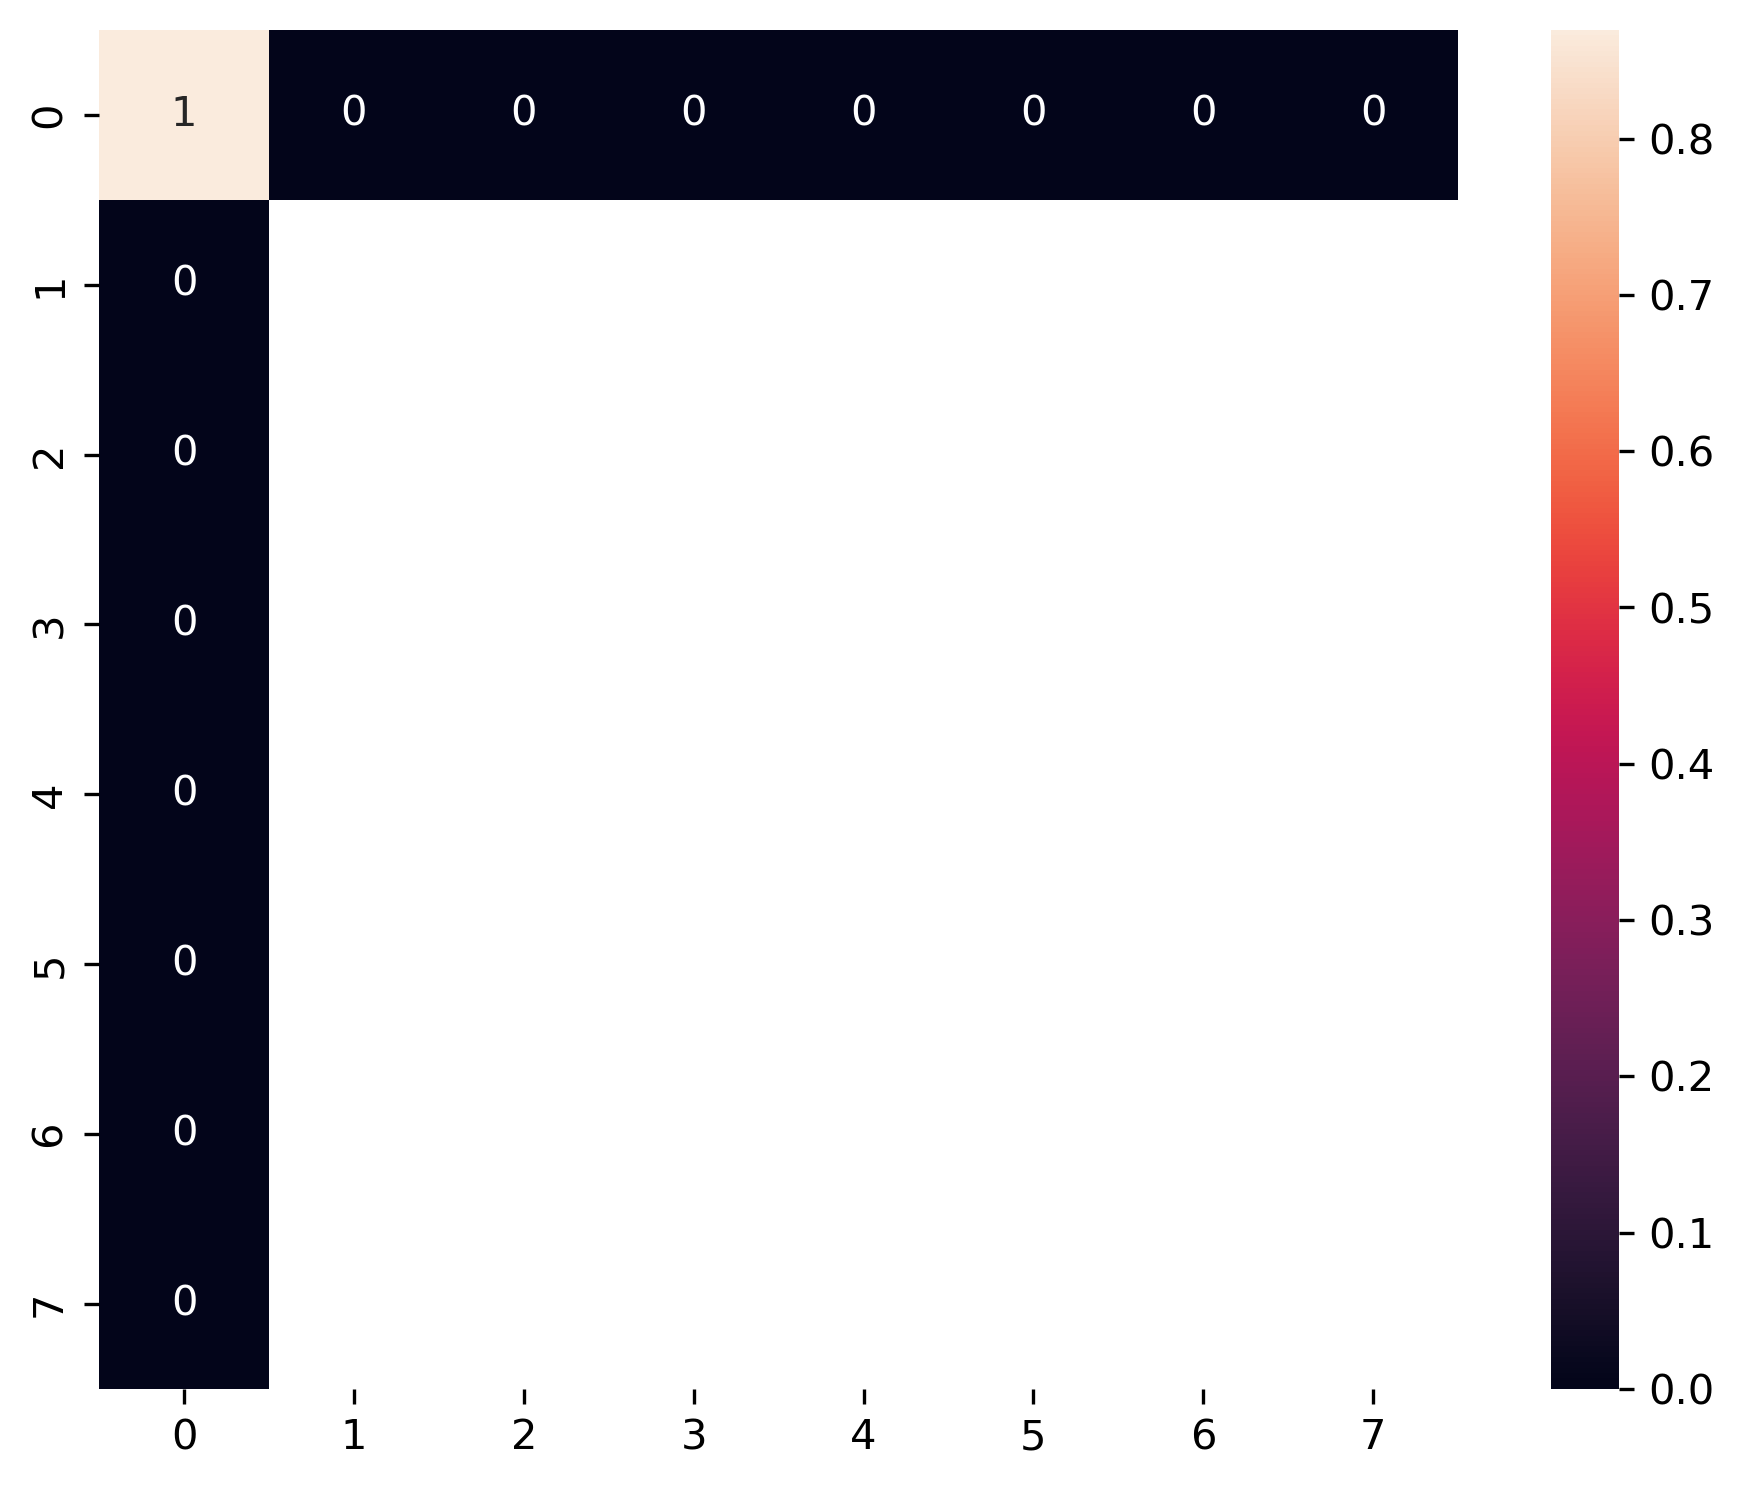

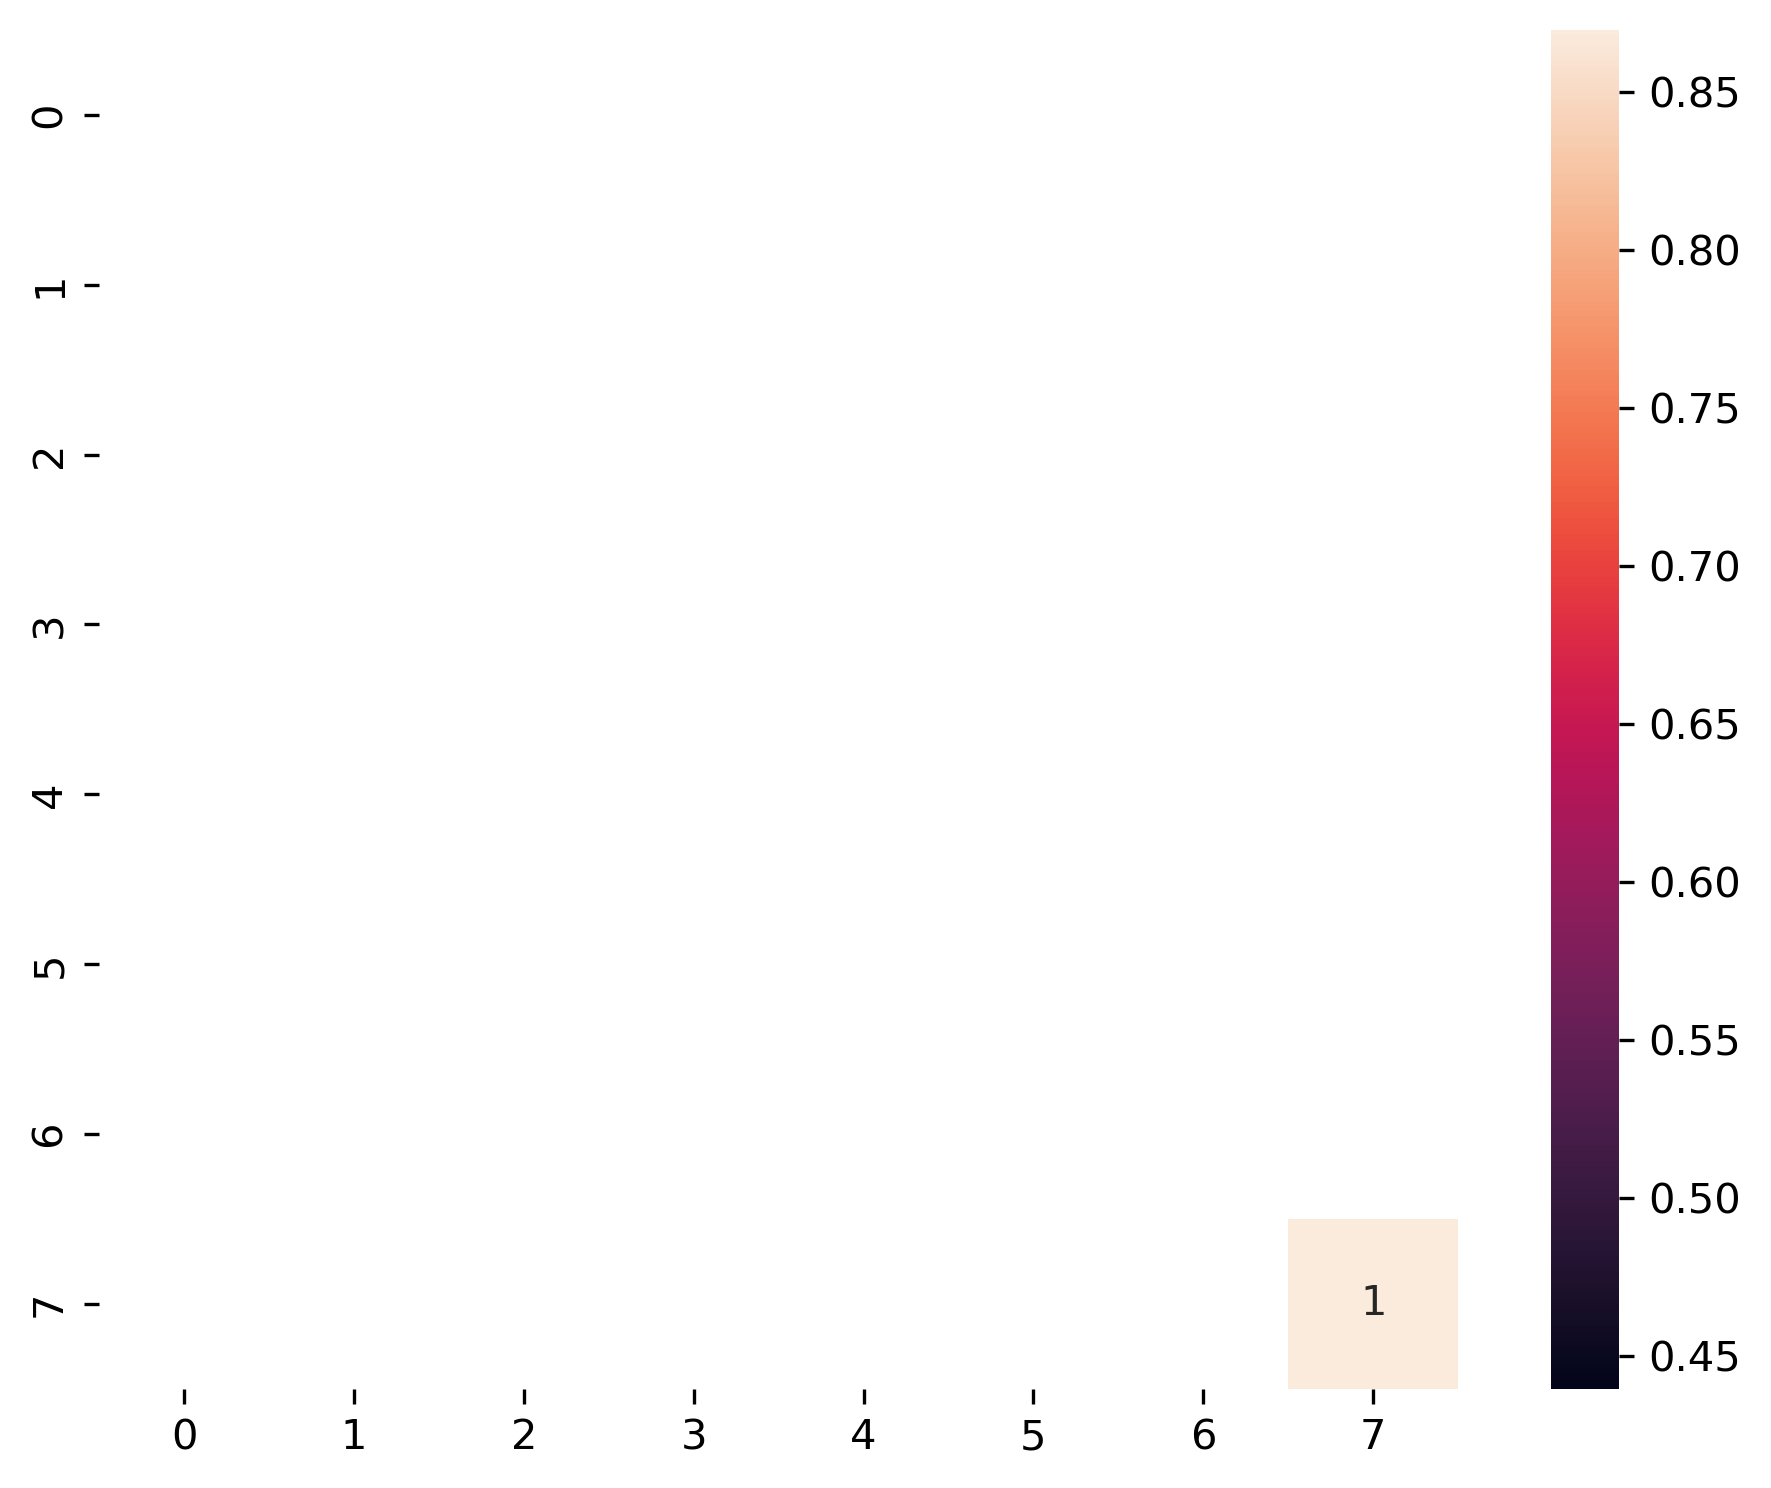

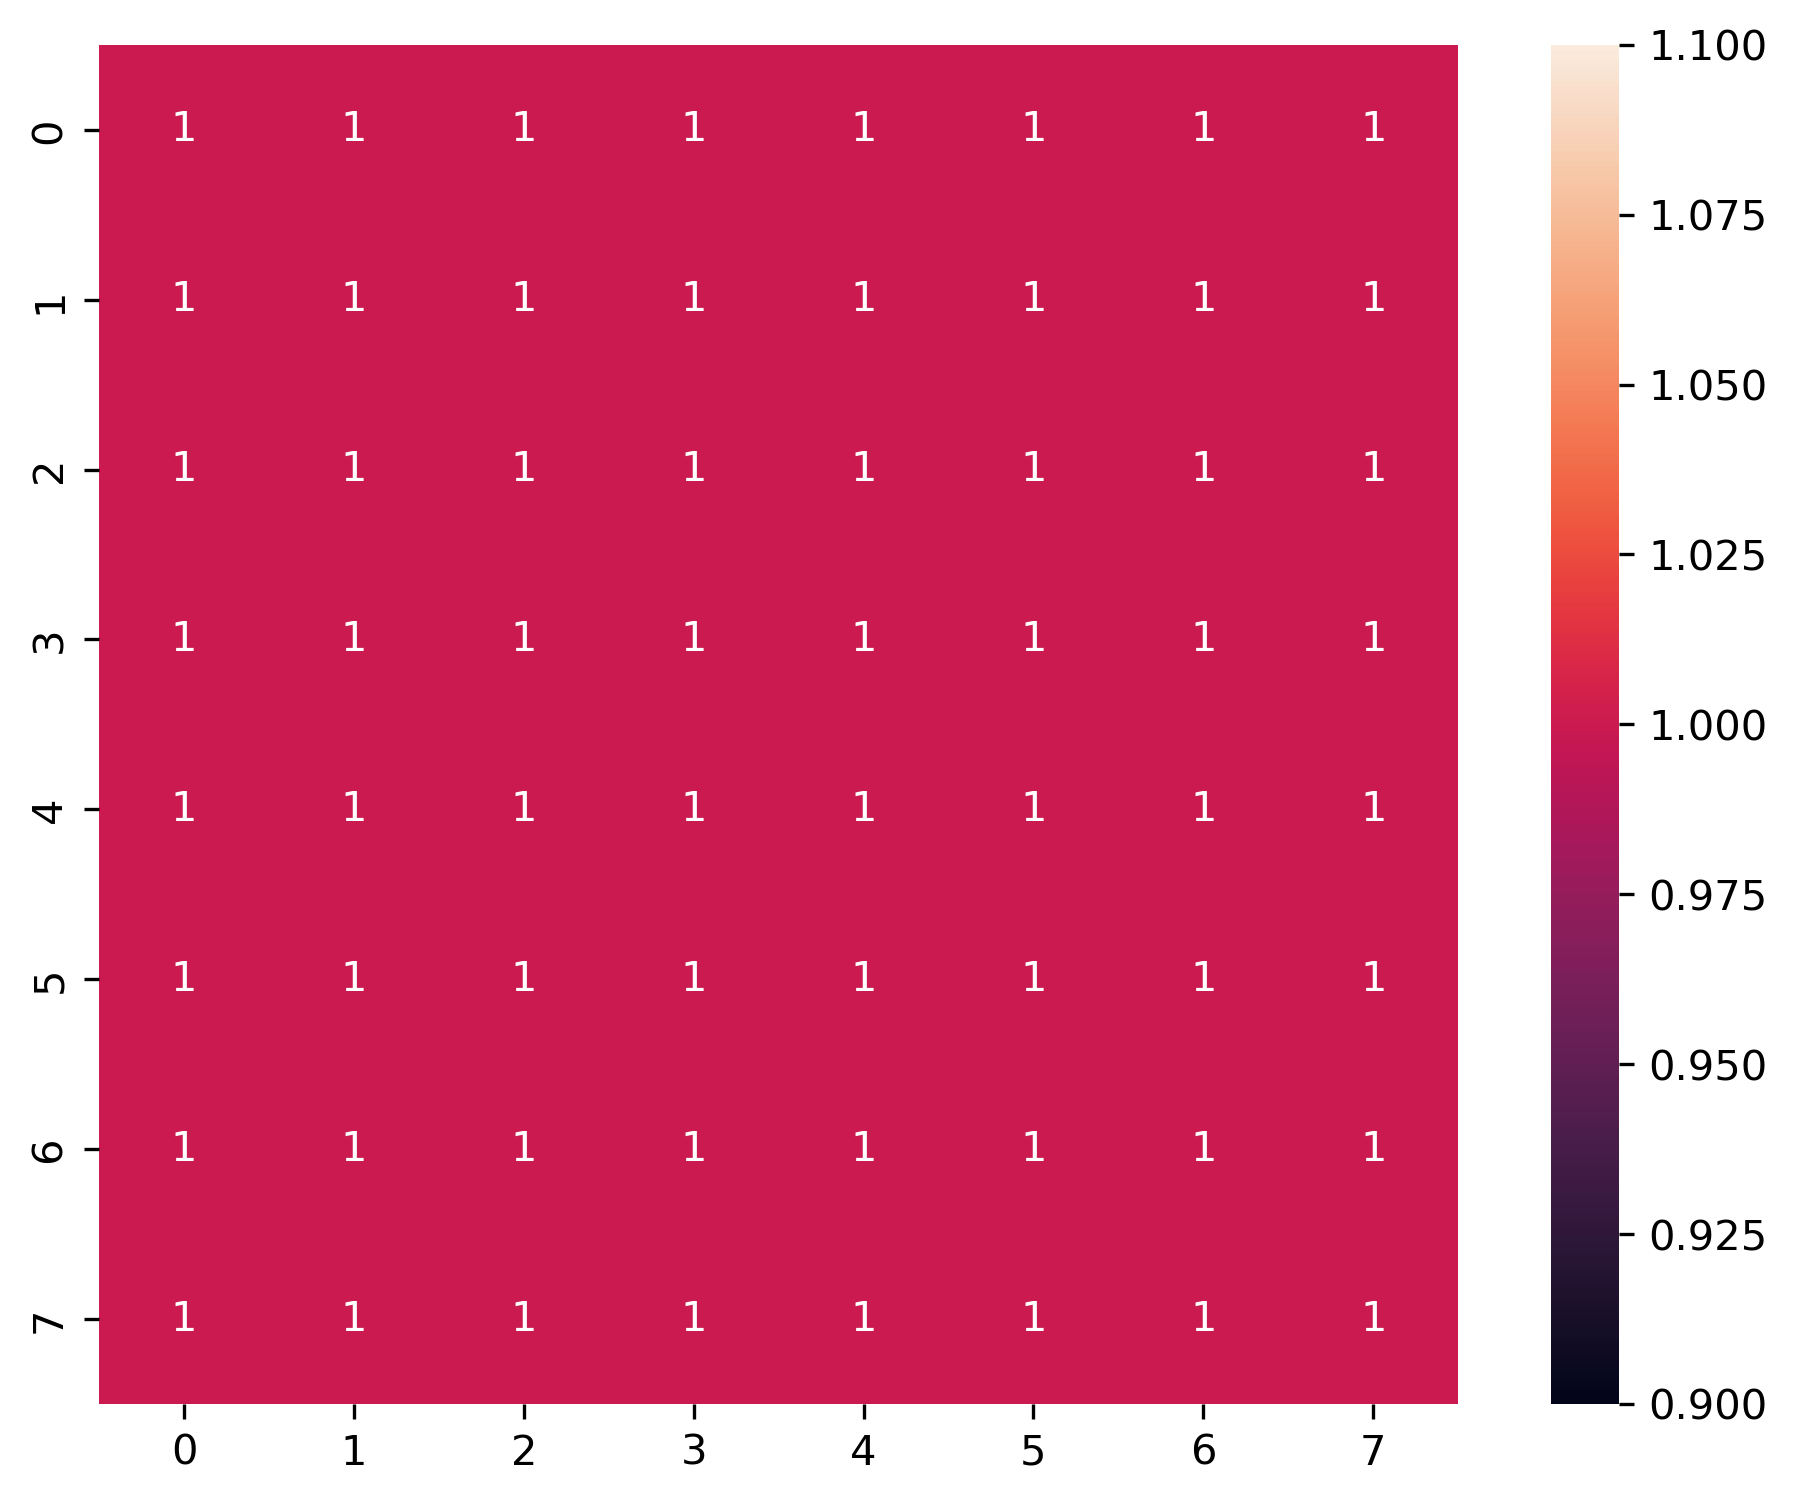

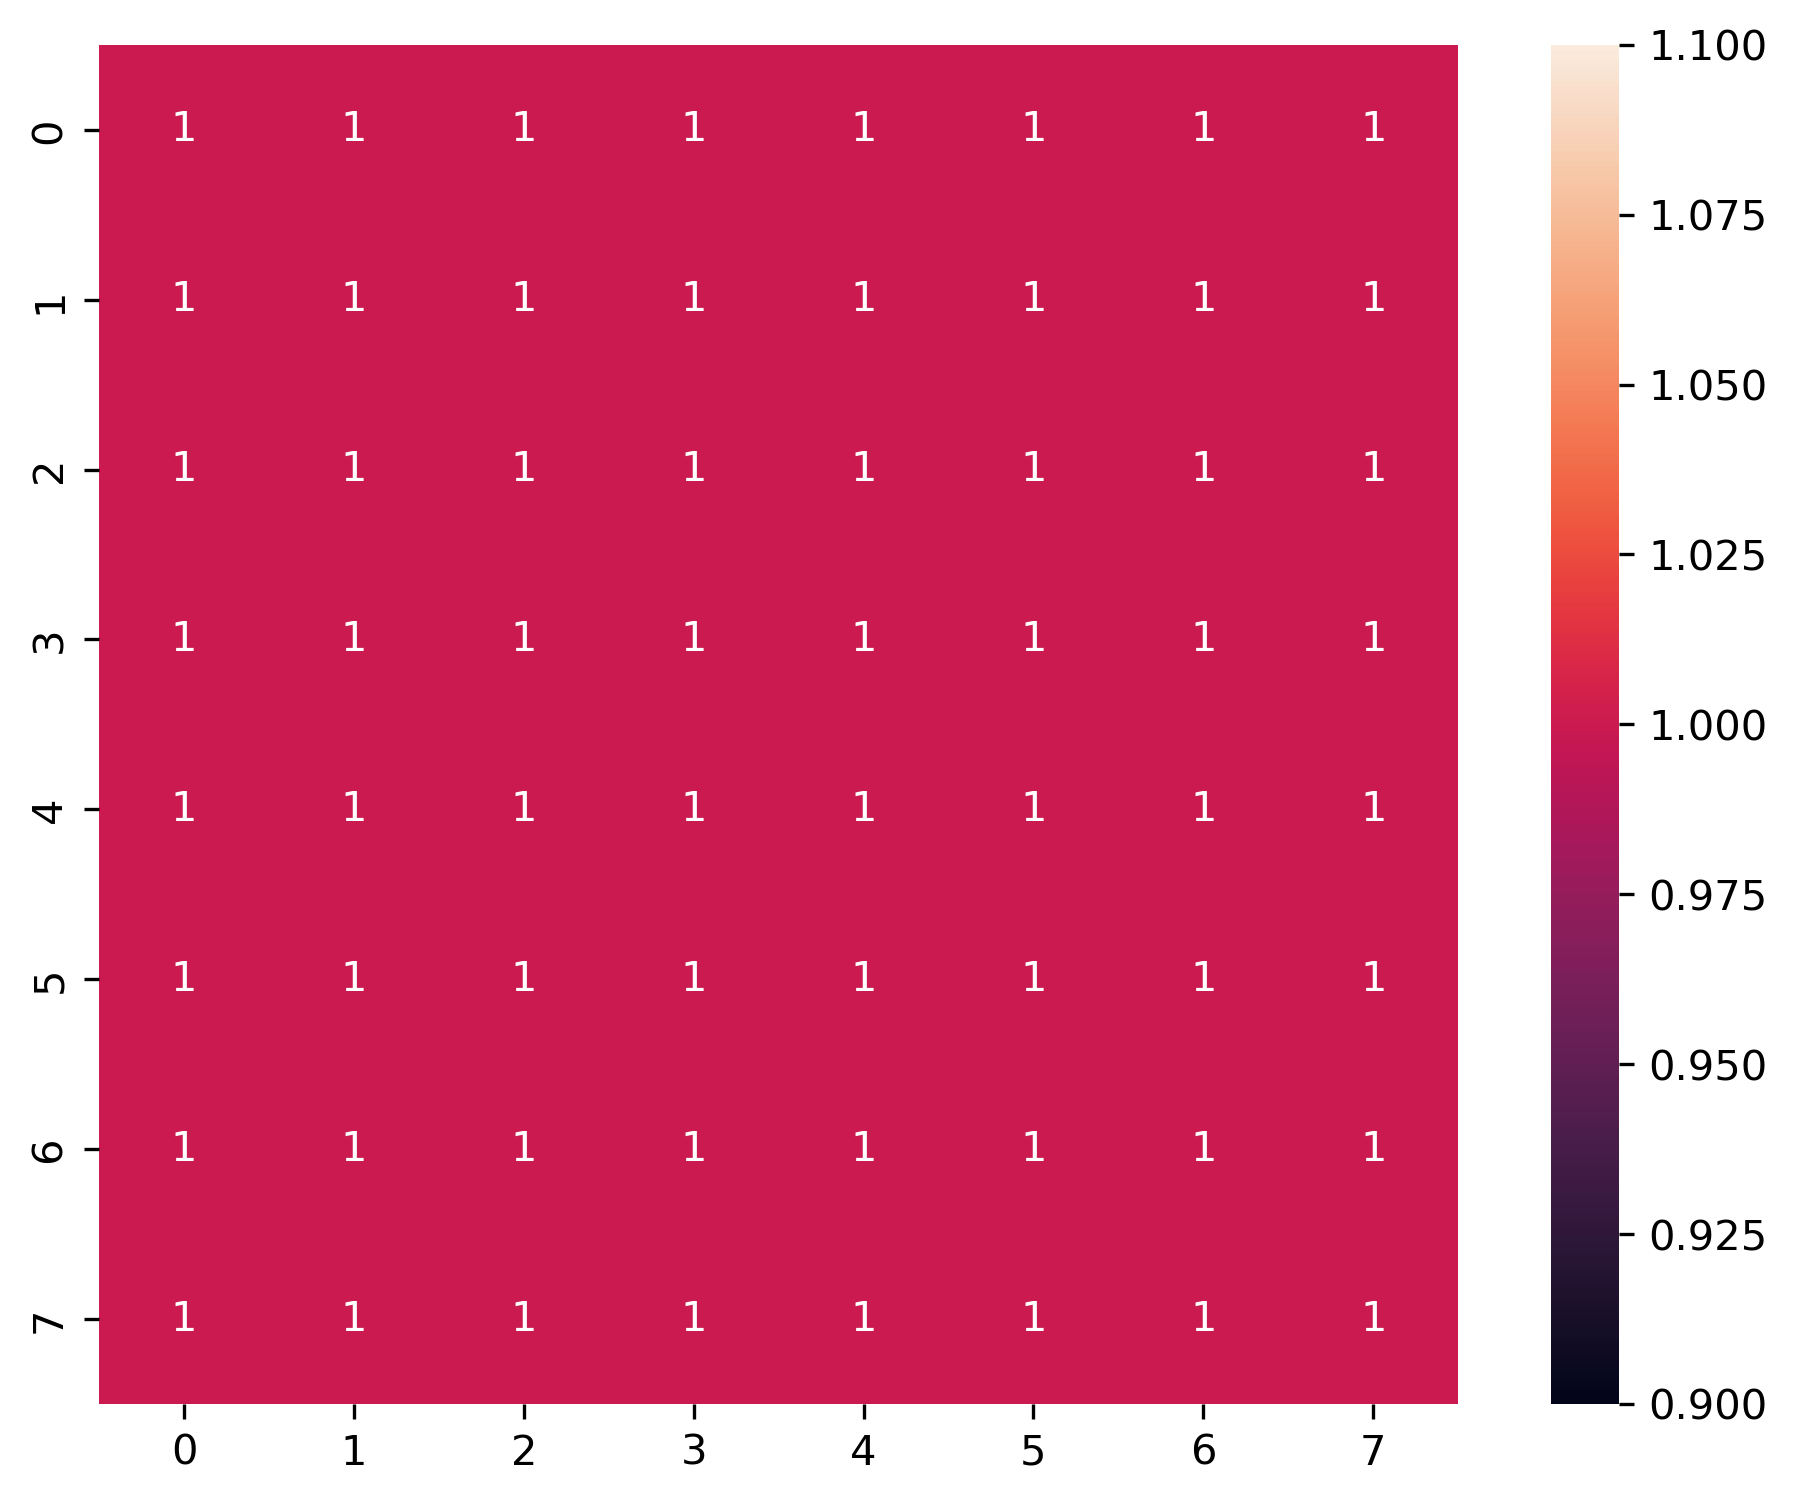

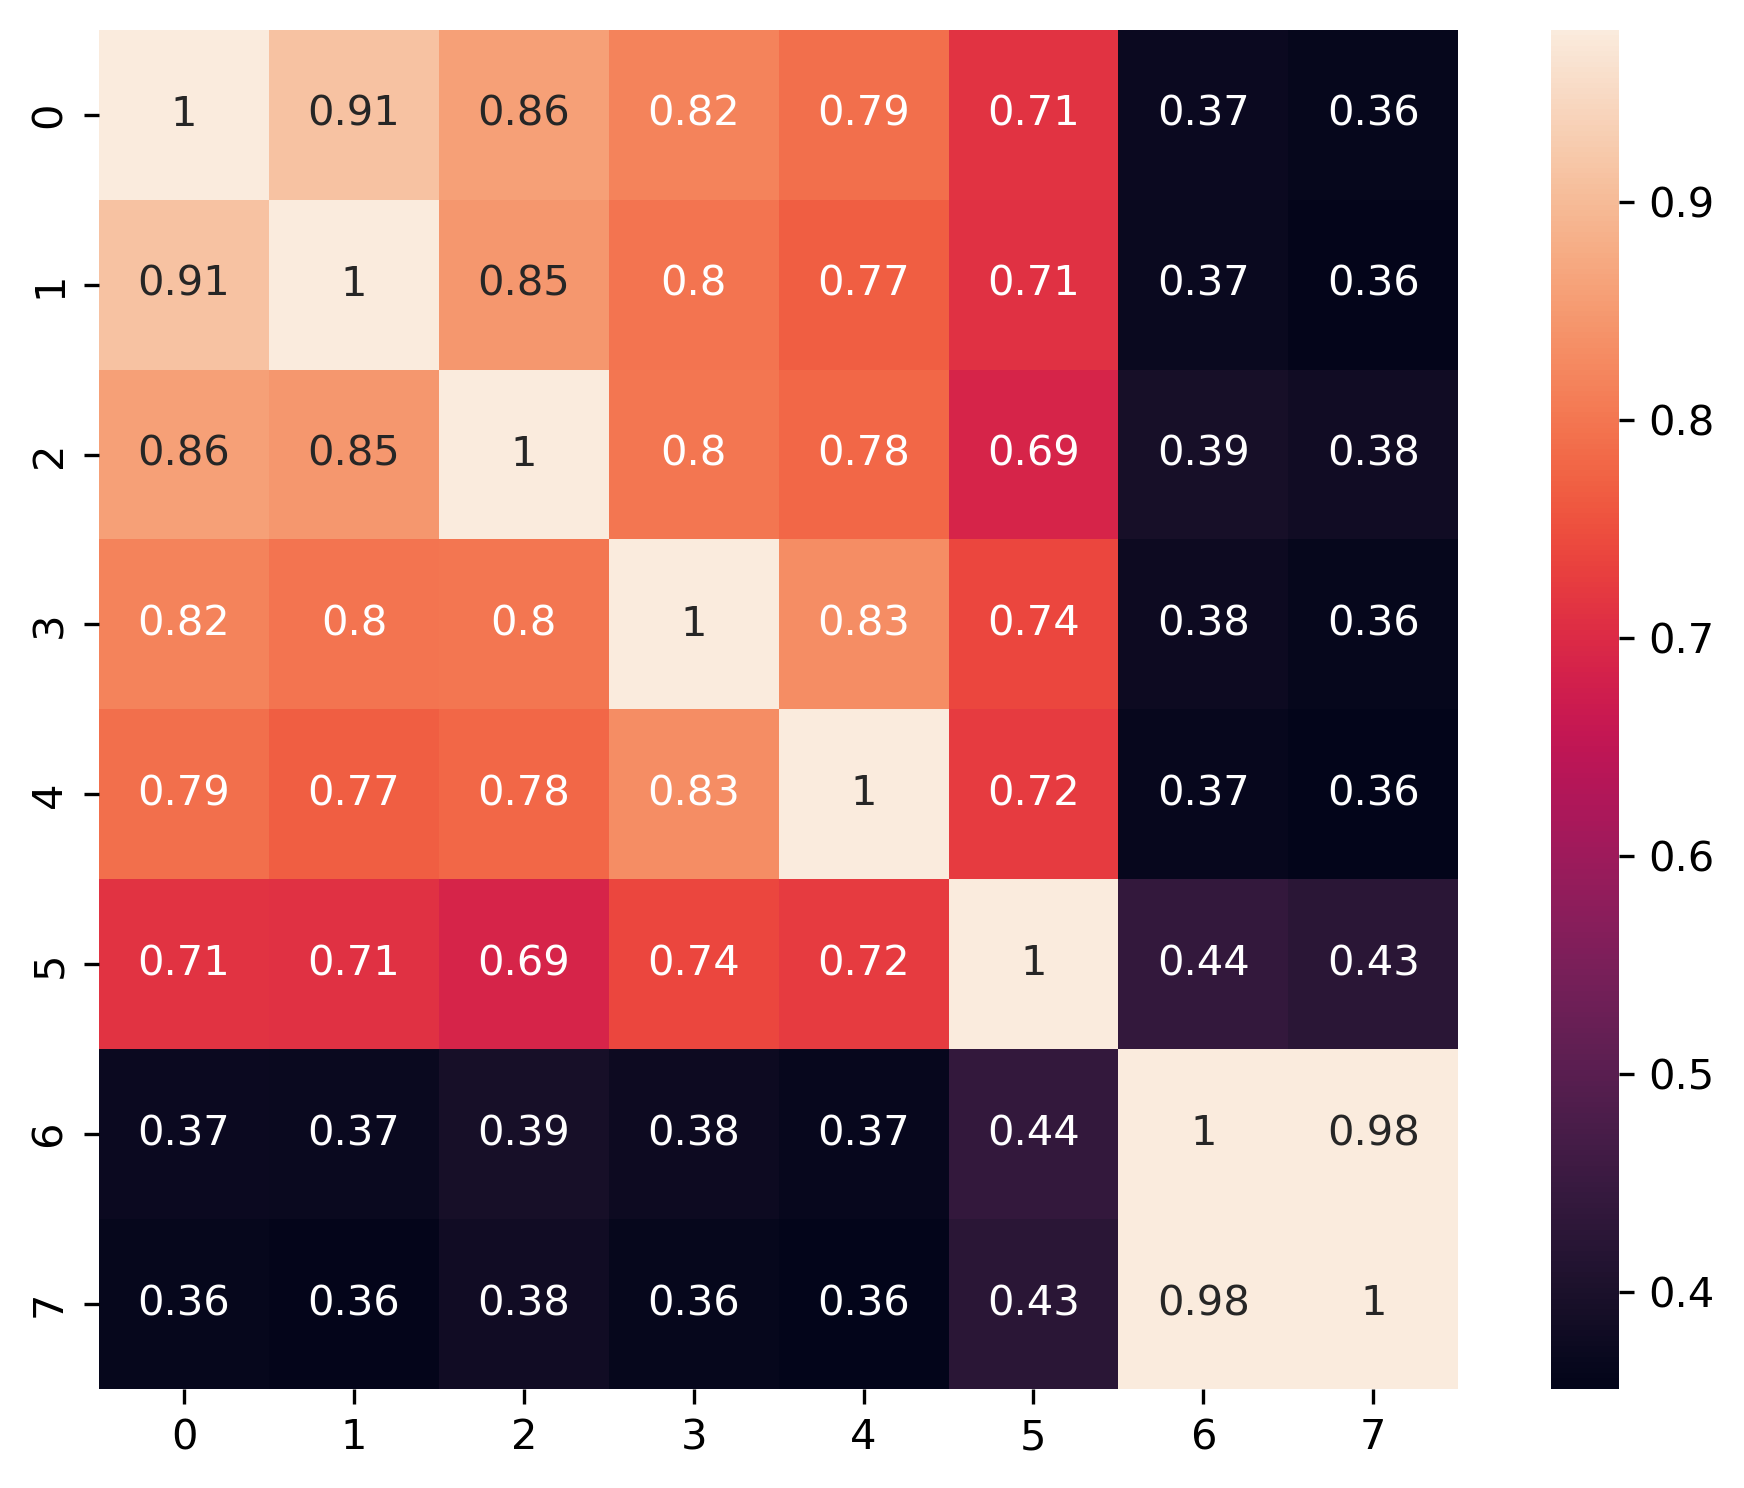

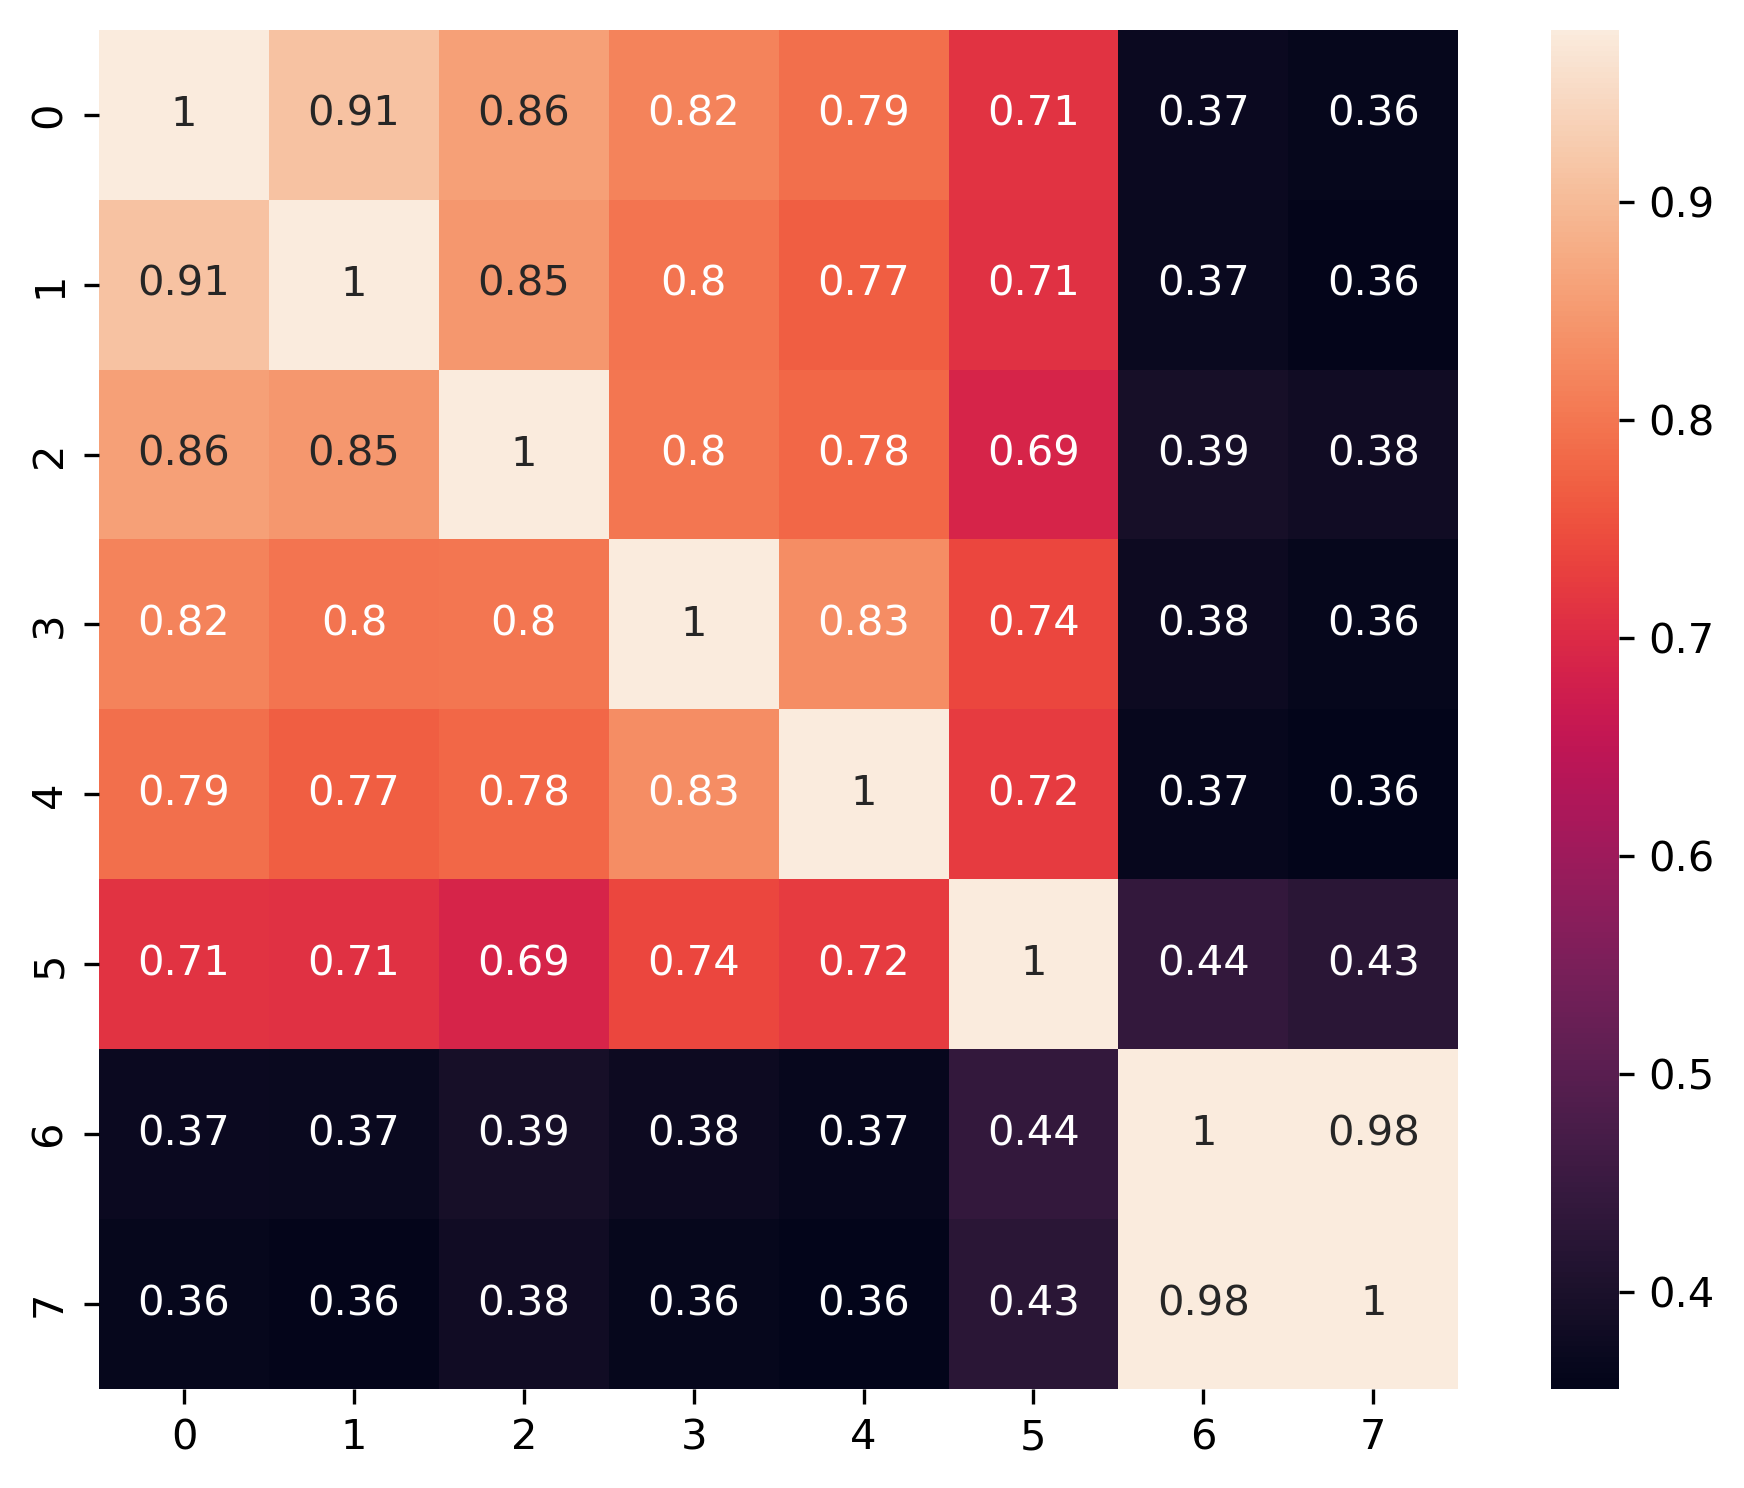

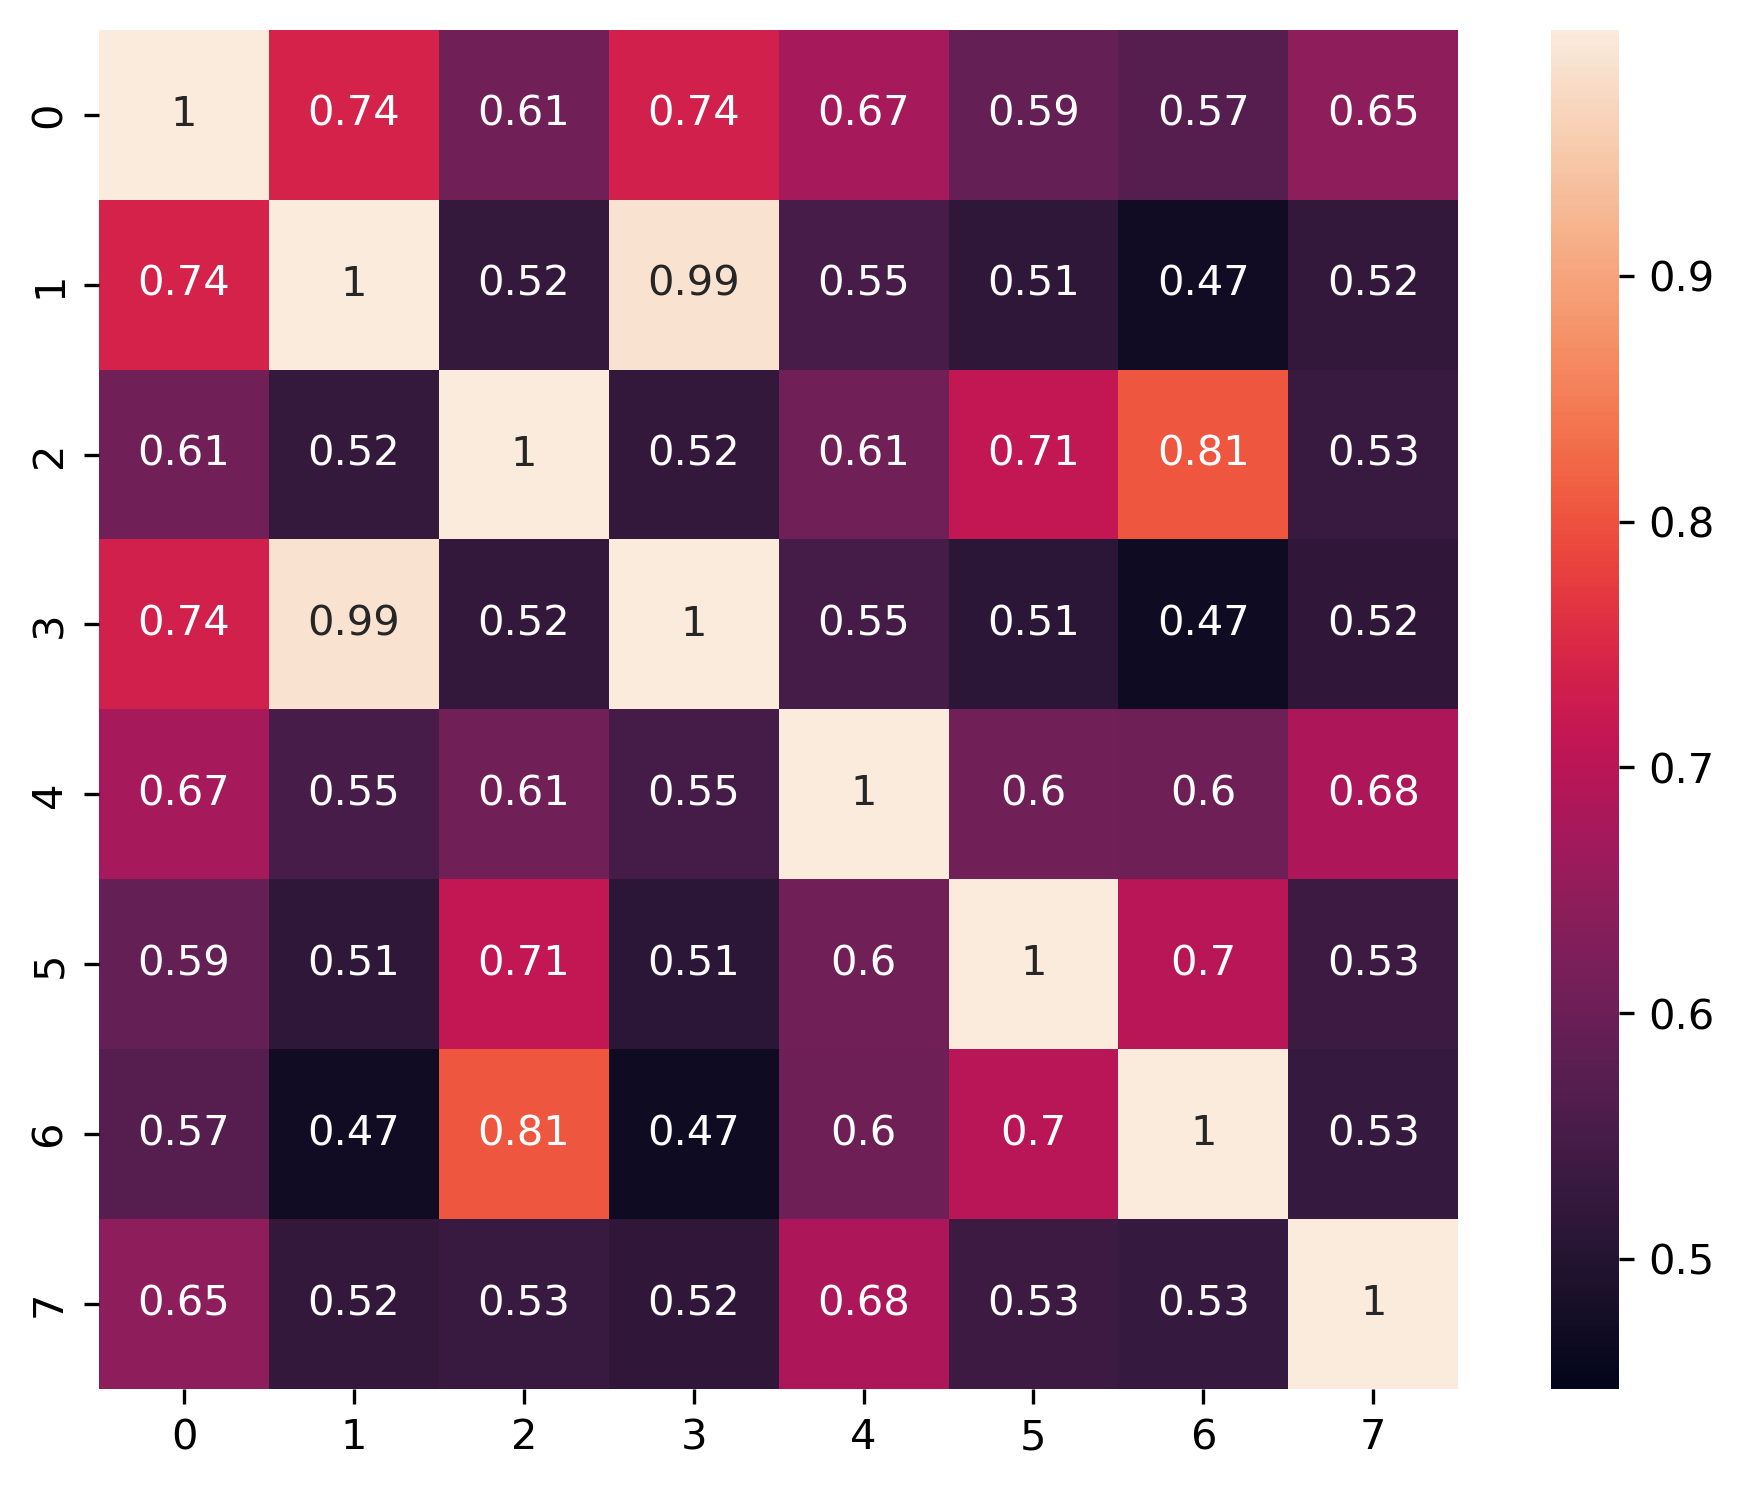

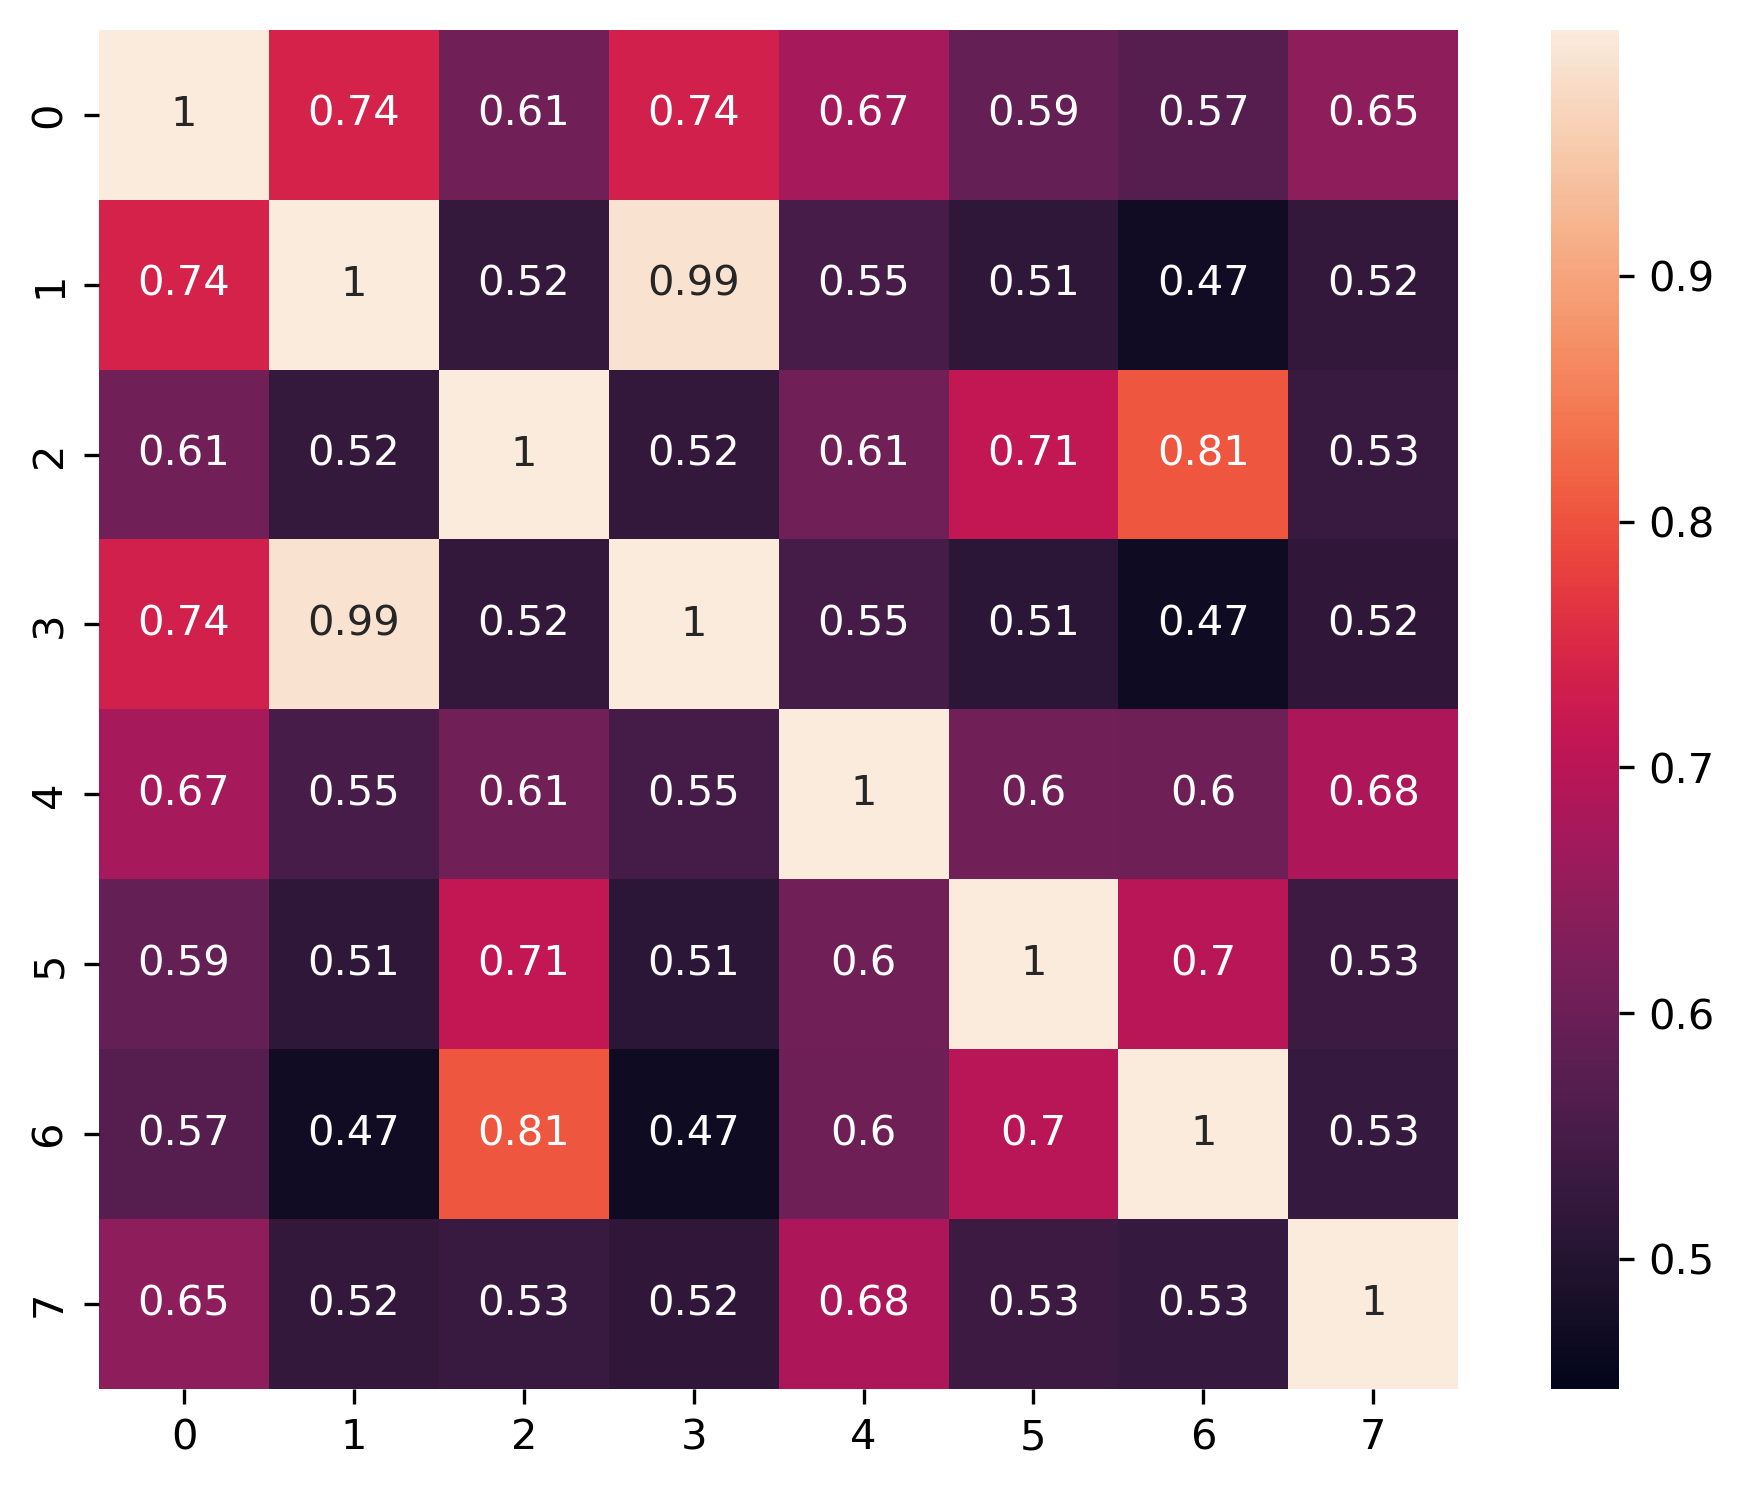

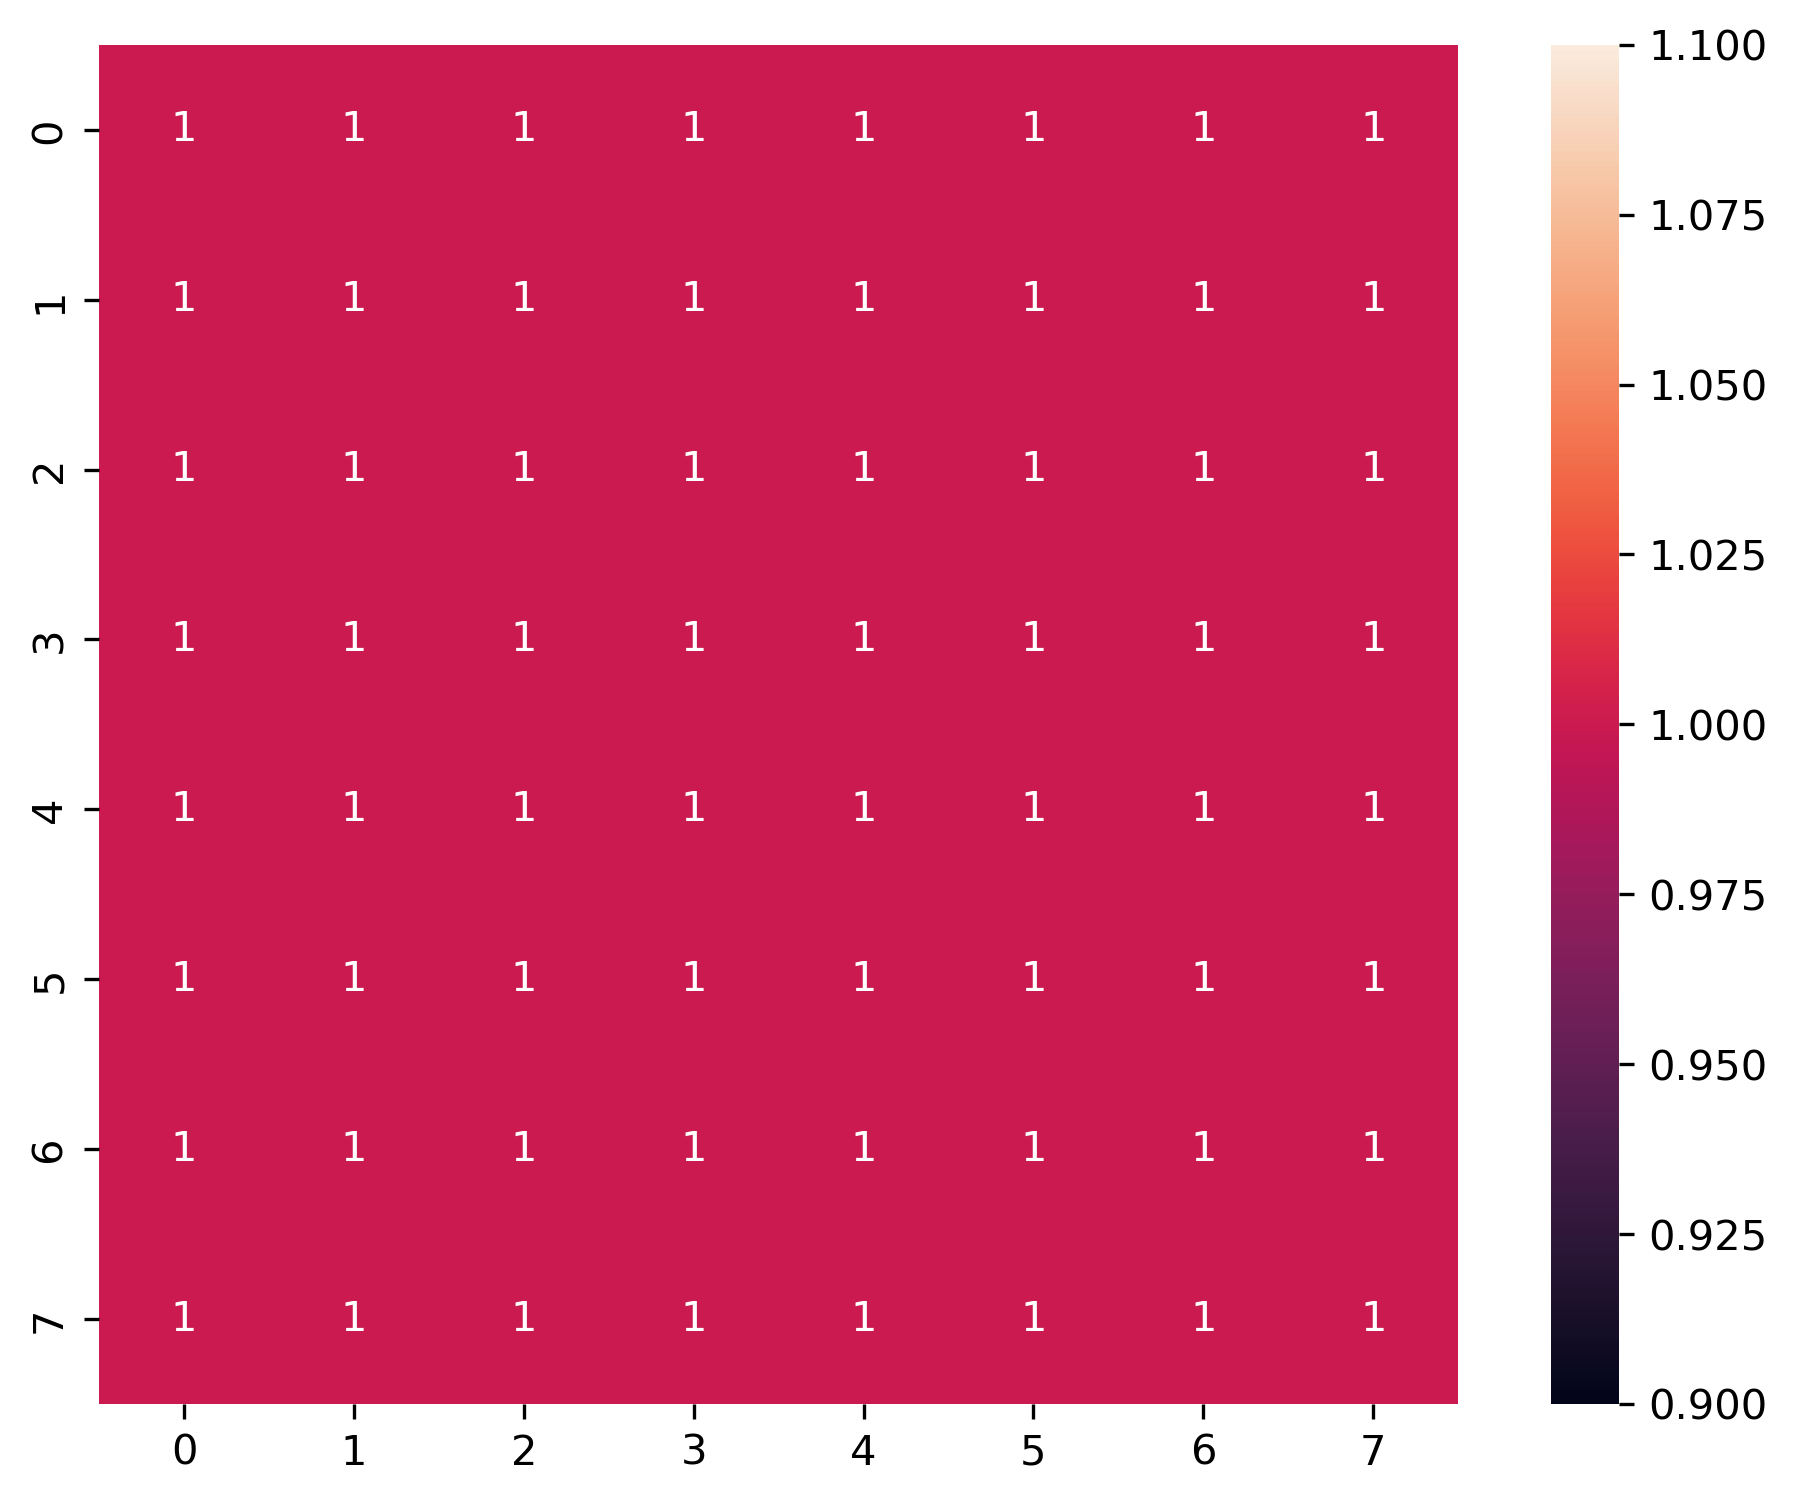

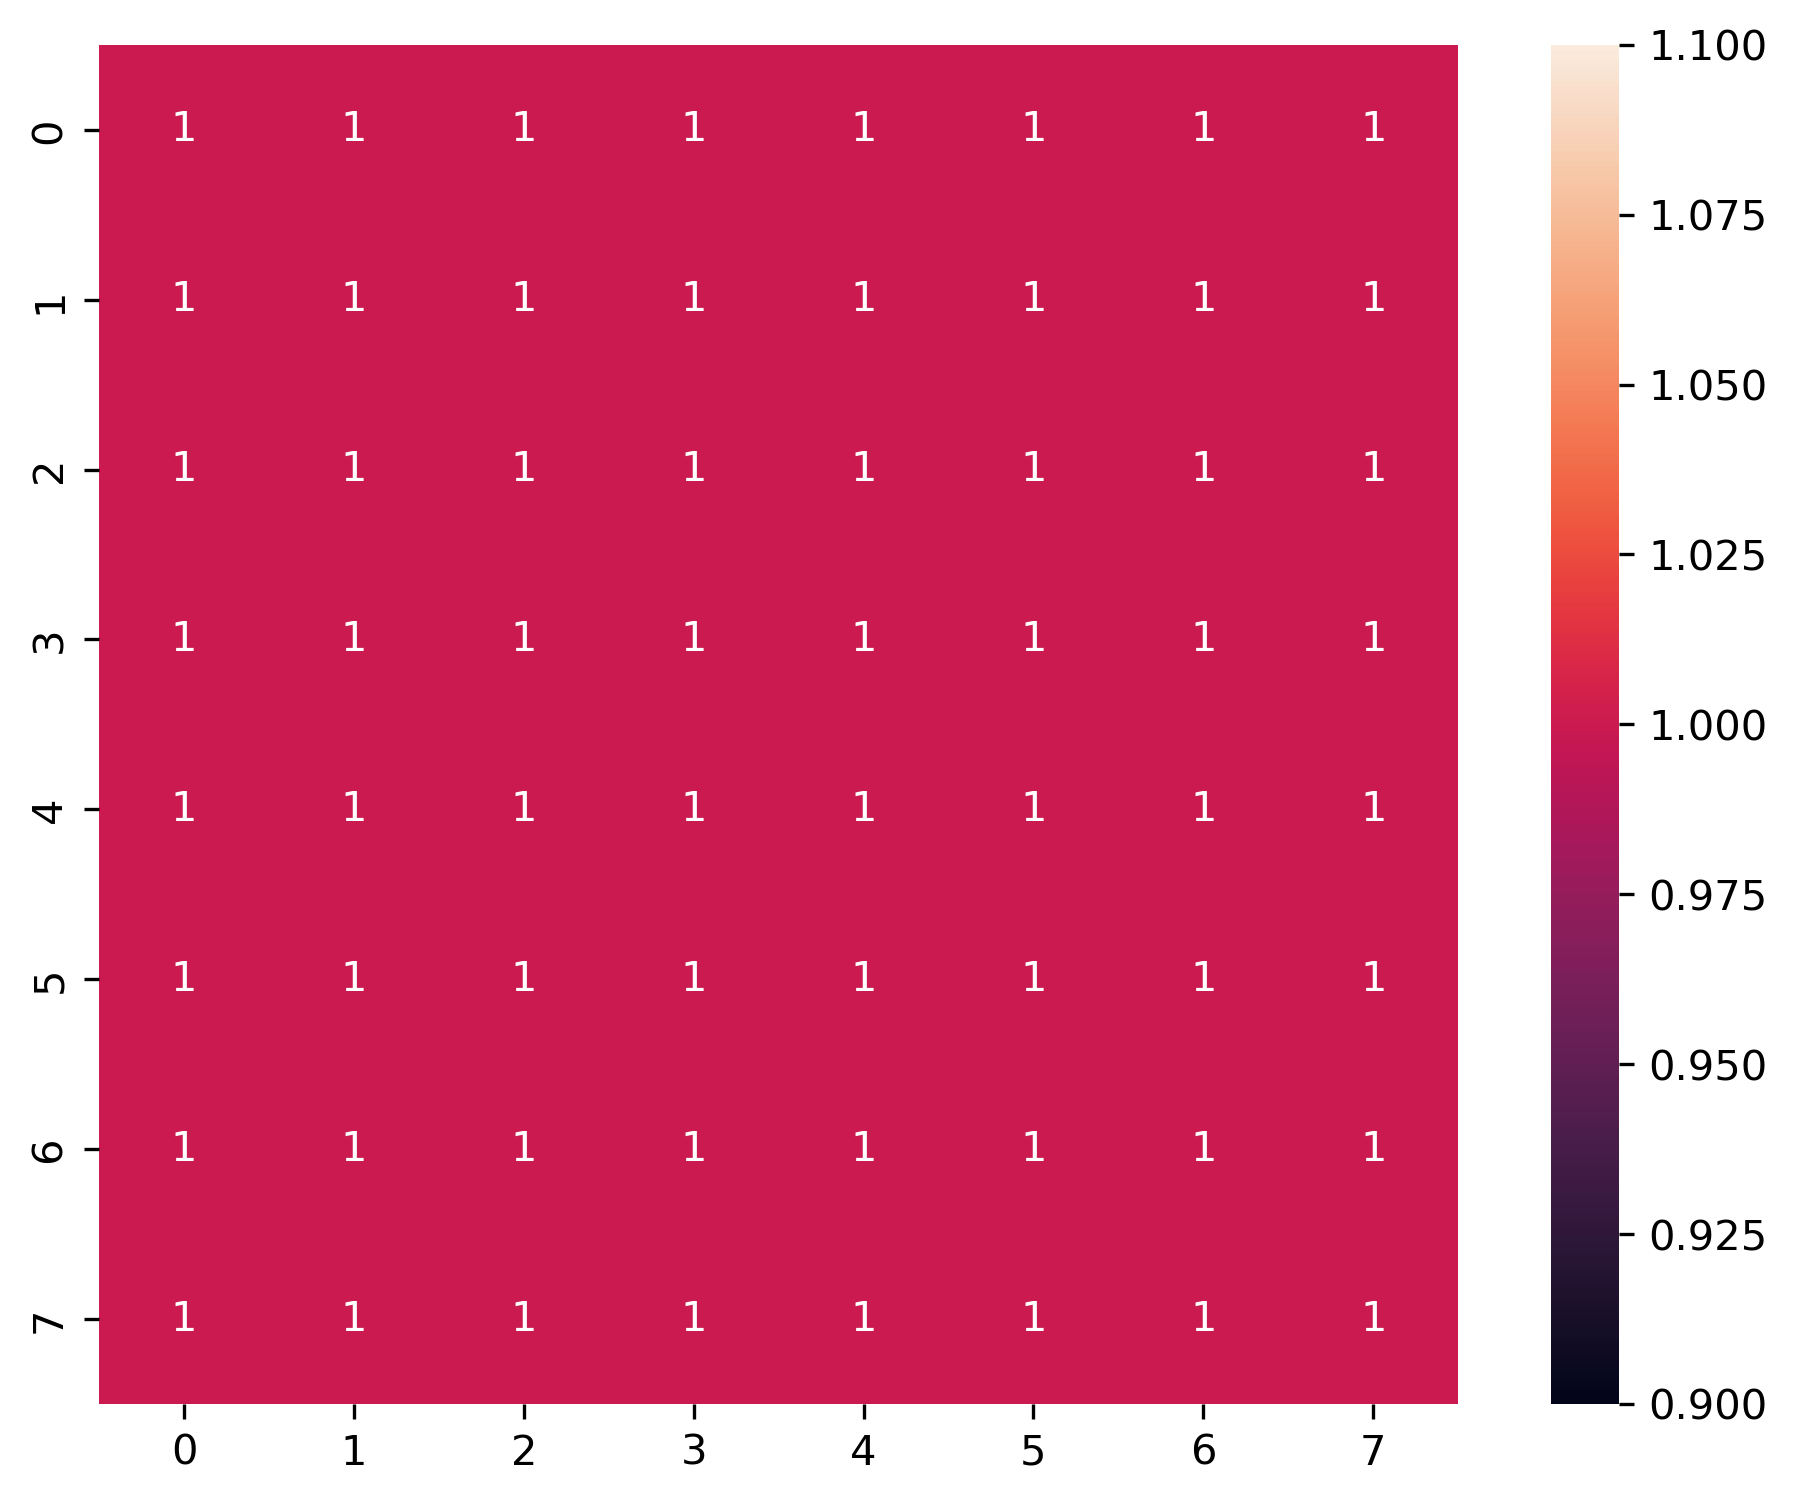

In [10]:
from annotator_metrics.src.metrics_evaluations import plot_figure
for score_tuple, score_entry in all_to_all.items():
        group_id = "group1"
        crop = score_tuple[0]
        organelle_name = score_tuple[1]
        metric_value = score_tuple[2]
        metric_name = score_entry["metric_name"]
        annotator_names = score_entry["annotator_names"]
        current_all_to_all = score_entry["scores_matrix"]
        score_range = score_ranges[(organelle_name, metric_value)]
        plot_figure(
                group_id,
                crop,
                organelle_name,
                metric_value,
                metric_name,
                annotator_names,
                current_all_to_all,
                score_range,
                output_path="/groups/cosem/cosem/ackermand/annotation_and_analytics/",
            )

In [ ]:
import numpy as np
all_to_all = {}
score_ranges = {}
for result in results:
    score_tuple = (result.crop,result.organelle_name,result.metric_value)
    if score_tuple not in all_to_all:
        all_to_all[score_tuple] = {
            "scores_matrix": np.zeros((len(result.annotator_names),len(result.annotator_names))),
            "annotator_names": result.annotator_names,
            "metric_name": result.metric_name
            }
    all_to_all[score_tuple]["scores_matrix"][result.gt_idx][result.test_idx] = result.score

    score_ranges_tuple = (result.organelle_name, result.metric_value)
    if score_ranges_tuple not in score_ranges:
        score_ranges[score_ranges_tuple]={
                        "min": np.nan_to_num(np.inf),
                        "max": np.nan_to_num(-np.inf),
                        "sorting": result.sorting,
                    }
    if result.gt_idx != result.test_idx:
        current_range = score_ranges[score_ranges_tuple]
        current_range["min"] = np.nanmin([current_range["min"], result.score])
        current_range["max"] = np.nanmax([current_range["max"], result.score])


In [ ]:
from matplotlib import pyplot as plt
import matplotlib
import seaborn
import os
import dask
from dask import delayed
from dask.distributed import Client


def plot_figure(crop, organelle_name, metric_value, metric_name, annotator_names, all_to_all, score_range):
    matplotlib.rcParams["figure.dpi"] = 300
    matplotlib.rcParams['axes.facecolor']='white'
    matplotlib.rcParams['savefig.facecolor']='white'

    _, ax = plt.subplots(1, 1, figsize=(8, 6),)
    if score_range["sorting"] == 1:  # low to high
        sort_order = np.argsort(np.nanmean(all_to_all, axis=1))
        cmap = "rocket_r"
    else:
        cmap = "rocket"
        sort_order = np.argsort(np.nanmean(all_to_all, axis=1))[
            ::-1
        ]

    all_to_all = all_to_all[:, sort_order]
    all_to_all = all_to_all[sort_order, :]
    annotator_names = [annotator_names[s] for s in sort_order]
    seaborn.heatmap(
        all_to_all,
        annot=True,
        square=True,
        vmin=score_range["min"],
        vmax=score_range["max"],
        cmap=cmap,
    )
    if score_range["sorting"] == 1:  # low to high
        plt.gcf().axes[1].invert_yaxis()

    ax.set_title(organelle_name)
    ax.collections[0].colorbar.set_label(metric_name)
    ax.xaxis.tick_top()
    plt.xticks(
        [i + 0.5 for i in range(len(annotator_names))],
        annotator_names,
        rotation=45,
        ha="left",
    )
    plt.yticks(
        [i + 0.5 for i in range(len(annotator_names))],
        annotator_names,
        rotation=0,
    )
    output_directory = (
        f"{input_base_path}/plots/{group}/{crop}/{metric_value}"
    )

    os.makedirs(output_directory, exist_ok=True)
    try:
        os.remove(f"{output_directory}/{organelle_name}.png")
    except OSError:
        pass
    plt.savefig(
        f"{output_directory}/{organelle_name}.png", bbox_inches="tight"
    )
    plt.close()

client = Client(n_workers=10, threads_per_worker=1)
print(client.dashboard_link)

group = "group01"
input_base_path = '/groups/cosem/cosem/ackermand/annotation_and_analytics/'
lazy_results = []
for score_tuple, score_entry in all_to_all.items():
    crop = score_tuple[0]
    organelle_name = score_tuple[1]
    metric_value = score_tuple[2]
    metric_name = score_entry["metric_name"]
    annotator_names = score_entry["annotator_names"]
    current_all_to_all = score_entry["scores_matrix"]
    score_range = score_ranges[(organelle_name, metric_value)]
    lazy_results.append(delayed(plot_figure)(crop, organelle_name, metric_value, metric_name, annotator_names, current_all_to_all, score_range))
    
dask.compute(*lazy_results)